In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#DATA LOADING

In [ ]:
df_2019_2023 = pd.read_csv(r'AQI_19-24(test).csv')


df_2019_2023['date'] = pd.to_datetime(df_2019_2023['date'])



df_2019_2023.set_index('date', inplace=True)

df_2019_2023



,AQI
date,
2019-01-01,138.335417
2019-01-02,136.497038
2019-01-03,140.986804
2019-01-04,131.428163
2019-01-05,135.004868
...,...
2023-12-27,146.537338
2023-12-28,136.862012
2023-12-29,158.328208


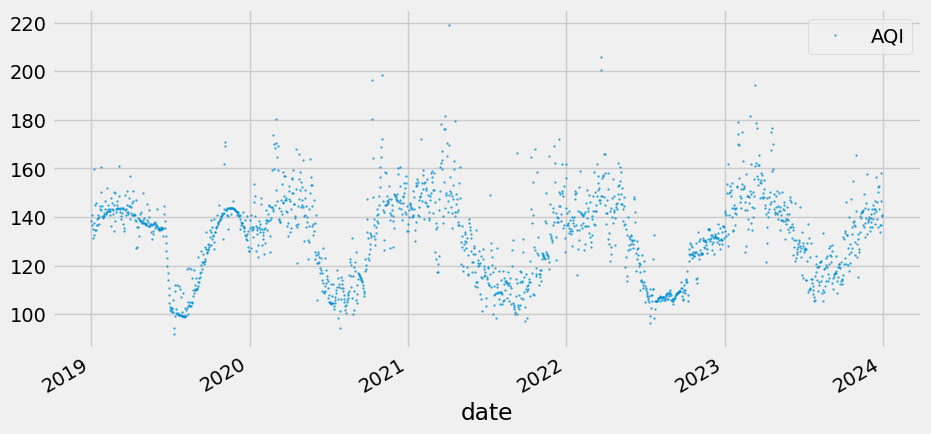

In [ ]:
# @title AQI

color_pal = sns.color_palette()
df_2019_2023.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='')
plt.show()

# detecting outlier and removing

,AQI
date,
2019-01-01,138.335417
2019-01-02,136.497038
2019-01-03,140.986804
2019-01-04,131.428163
2019-01-05,135.004868
...,...
2023-12-27,146.537338
2023-12-28,136.862012
2023-12-29,158.328208


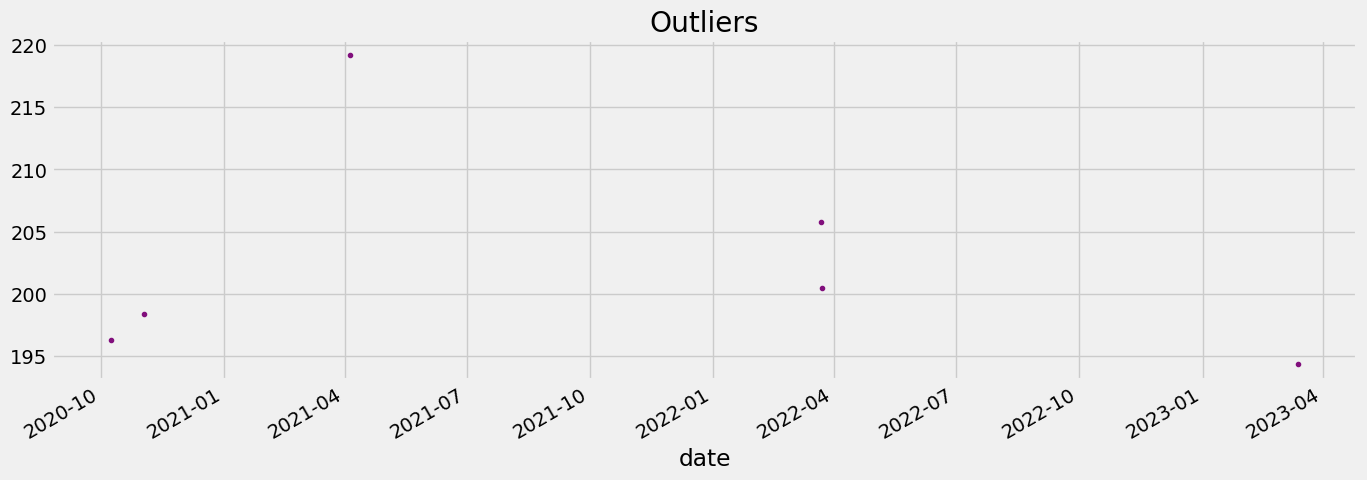

In [ ]:

 mean, std = df_2019_2023['AQI'].mean(), df_2019_2023['AQI'].std()
df_2019_2023.query('AQI < @mean - 3*@std or AQI > @mean + 3*@std')['AQI'].plot(
    style='.', figsize=(15, 5), color=color_pal[5], title='Outliers'
)
df_2019_2023



In [ ]:
df_2019_2023 = df_2019_2023.query('AQI > 80').copy()
df_2019_2023 = df_2019_2023.query('AQI < 184').copy()
df_2019_2023


,AQI
date,
2019-01-01,138.335417
2019-01-02,136.497038
2019-01-03,140.986804
2019-01-04,131.428163
2019-01-05,135.004868
...,...
2023-12-27,146.537338
2023-12-28,136.862012
2023-12-29,158.328208


Index(['AQI'], dtype='object')


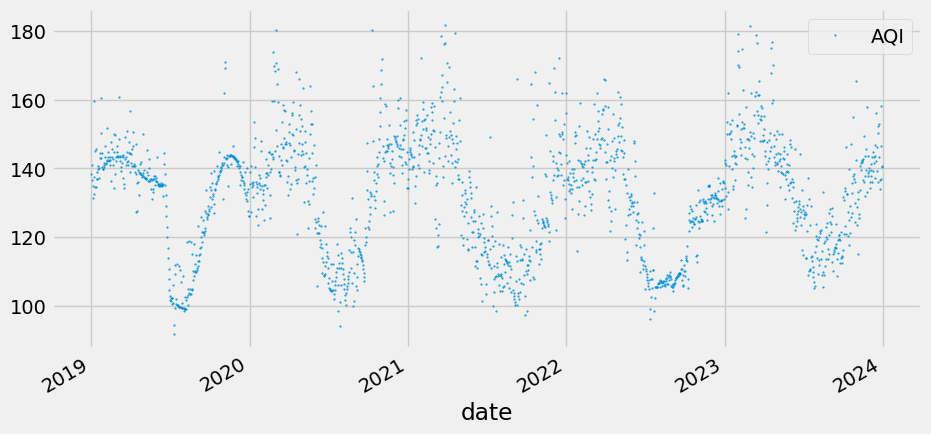

Index(['AQI'], dtype='object')


In [ ]:
print(df_2019_2023.columns)

color_pal = sns.color_palette()
df_2019_2023.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='')
plt.show()
print(df_2019_2023.columns)


In [ ]:
df_2019_2023.reset_index(inplace=True)
df_2019_2023.columns

Index(['date', 'AQI'], dtype='object')

In [ ]:
df_2019_2023.reset_index()
print(df_2019_2023)


           date         AQI
0    2019-01-01  138.335417
1    2019-01-02  136.497038
2    2019-01-03  140.986804
3    2019-01-04  131.428163
4    2019-01-05  135.004868
...         ...         ...
1814 2023-12-27  146.537338
1815 2023-12-28  136.862012
1816 2023-12-29  158.328208
1817 2023-12-30  140.680083
1818 2023-12-31  140.530320

[1819 rows x 2 columns]


#FEATURE CREATION

In [ ]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar

df_2019_2023.reset_index(drop=True, inplace=True)
df_2019_2023['date'] = pd.to_datetime(df_2019_2023['date'], format='%d/%m/%Y', errors='coerce')

df_prophet = df_2019_2023[['date', 'AQI']].rename(columns={'date': 'ds', 'AQI': 'y'})

df_prophet['rolling_mean_7'] = df_prophet['y'].rolling(window=7).mean()
df_prophet['rolling_mean_30'] = df_prophet['y'].rolling(window=30).mean()

df_prophet['monthly_avg'] = df_prophet.groupby(df_prophet['ds'].dt.month)['y'].transform('mean')
df_prophet['quarter'] = df_prophet['ds'].dt.quarter

df_prophet['lag_1'] = df_prophet['y'].shift(1)
df_prophet['lag_7'] = df_prophet['y'].shift(7)
df_prophet['lag_30'] = df_prophet['y'].shift(30)

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df_prophet['ds'].min(), end=df_prophet['ds'].max())
df_prophet['is_holiday'] = df_prophet['ds'].isin(holidays).astype(int)

df_prophet['day_of_week'] = df_prophet['ds'].dt.dayofweek
df_prophet['is_weekend'] = np.where(df_prophet['day_of_week'] >= 5, 1, 0)

df_prophet = df_prophet.dropna()

print(f"Number of rows after dropping NaN values: {df_prophet.shape[0]}")
print(df_prophet.head())


Index(['date', 'AQI'], dtype='object')
Number of rows after dropping NaN values: 1789
           ds           y  rolling_mean_7  rolling_mean_30  monthly_avg  \
30 2019-01-31  140.981786      141.066974       141.105426   141.229067   
31 2019-02-01  143.421576      141.501216       141.336244   145.360022   
32 2019-02-02  146.446378      141.795075       141.518230   145.360022   
33 2019-02-03  141.627831      142.065504       141.858219   145.360022   
34 2019-02-04  141.356050      142.271435       142.069925   145.360022   

    quarter       lag_1       lag_7      lag_30  is_holiday  day_of_week  \
30        1  140.369794  143.000180  138.335417           0            3   
31        1  140.981786  140.381882  136.497038           0            4   
32        1  143.421576  144.389359  140.986804           0            5   
33        1  146.446378  139.734832  131.428163           0            6   
34        1  141.627831  139.914534  135.004868           0            0   

    is

#Hyperparamters tuning ,Evaluation & OverFiiting/Underfitting Check

In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product
from prophet.diagnostics import cross_validation, performance_metrics


# Split the data into training and testing sets
df_prophet.reset_index(drop=True, inplace=True)

split_date = '2023-01-01'  # Ensure the format matches the `ds` column format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], format='%Y-%m-%d')  # Convert 'ds' to datetime if it's not
AQI_train = df_prophet.loc[df_prophet['ds'] <= split_date].copy()  # Training data
AQI_test = df_prophet.loc[df_prophet['ds'] > split_date].copy()  # Test data
# AQI_train.drop(columns=['level_0', 'index'], inplace=True)
# AQI_test.drop(columns=['level_0', 'index'], inplace=True)

# Define the Prophet model with additional features
def prophet_model(changepoint_prior_scale=0.05, seasonality_prior_scale=10.0, holidays_prior_scale=10.0, seasonality_mode='additive'):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale,
        seasonality_mode=seasonality_mode
    )

    # Add custom features (e.g., holidays and additional regressors)
    model.add_regressor('rolling_mean_7')
    model.add_regressor('rolling_mean_30')
    model.add_regressor('monthly_avg')
    model.add_regressor('quarter')
    model.add_regressor('lag_1')
    model.add_regressor('lag_7')
    model.add_regressor('lag_30')
    model.add_regressor('is_holiday')
    model.add_regressor('day_of_week')
    model.add_regressor('is_weekend')

    return model

# Parameter grid for grid search
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.2],
    'seasonality_prior_scale': [1.0, 5.0, 10.0, 20.0, 30.0],
    'holidays_prior_scale': [1.0, 5.0, 10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative'],
}

# Function to perform cross-validation and compute performance metrics
def evaluate_model(params):
    model = prophet_model(**params)
    # Fit the model on the training data
    model.fit(AQI_train[['ds', 'y', 'rolling_mean_7', 'rolling_mean_30', 'monthly_avg', 'quarter',
                          'lag_1', 'lag_7', 'lag_30', 'is_holiday', 'day_of_week', 'is_weekend']])

    # Perform time series cross-validation on the training data
    cv_results = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    performance = performance_metrics(cv_results)

    rmse_val = performance['rmse'].mean()
    mae_val = performance['mae'].mean()

    # Calculate training RMSE and MAE
    train_forecast = model.predict(AQI_train[['ds', 'rolling_mean_7', 'rolling_mean_30', 'monthly_avg',
                                               'quarter', 'lag_1', 'lag_7', 'lag_30', 'is_holiday',
                                               'day_of_week', 'is_weekend']])
    rmse_train = mean_squared_error(AQI_train['y'], train_forecast['yhat'], squared=False)
    mae_train = mean_absolute_error(AQI_train['y'], train_forecast['yhat'])

    return rmse_train, mae_train, rmse_val, mae_val

# Run grid search with time series cross-validation on the training set
best_params = None
best_rmse_val = float('inf')
best_mae_val = float('inf')

# Store RMSE and MAE values for each parameter combination
rmse_train_values, mae_train_values = [], []
rmse_val_values, mae_val_values = [], []
param_combinations = []

# Generate all combinations of parameters
for params in [dict(zip(param_grid, x)) for x in product(*param_grid.values())]:
    rmse_train, mae_train, rmse_val, mae_val = evaluate_model(params)
    rmse_train_values.append(rmse_train)
    mae_train_values.append(mae_train)
    rmse_val_values.append(rmse_val)
    mae_val_values.append(mae_val)
    param_combinations.append(params)

    # Update best parameters if current validation RMSE and MAE are better
    if rmse_val < best_rmse_val and mae_val < best_mae_val:
        best_rmse_val = rmse_val
        best_mae_val = mae_val
        best_params = params

    # Determine if the model is overfitting, underfitting, or well-fitted
    if rmse_train < rmse_val * 0.8 and mae_train < mae_val * 0.8:
        fit_status = "Overfitting"
    elif rmse_train > rmse_val * 1.2 and mae_train > mae_val * 1.2:
        fit_status = "Underfitting"
    else:
        fit_status = "Good Fit"

    print(f"Params: {params}")
    print(f"Training RMSE: {rmse_train}, Validation RMSE: {rmse_val}")
    print(f"Training MAE: {mae_train}, Validation MAE: {mae_val}")
    print(f"Fit Status: {fit_status}\n")

print(f'Best parameters: {best_params}')
print(f'Best Validation RMSE: {best_rmse_val}')
print(f'Best Validation MAE: {best_mae_val}')


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pcw4yy2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j9wmj7u6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30123', 'data', 'file=/tmp/tmp7kdwv740/pcw4yy2u.json', 'init=/tmp/tmp7kdwv740/j9wmj7u6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln65h41d4/prophet_model-20241115101543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fbpt_2mq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ehskr_jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25126', 'data', 'file=/tmp/tmp7kdwv740/fbpt_2mq.json', 'init=/tmp/tmp7kdwv740/ehskr_jr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelzvvoq10l/prophet_model-20241115101543.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mlttujxs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zveo6jxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.301796066746354, Validation RMSE: 7.8507121796266
Training MAE: 5.102274654454214, Validation MAE: 5.70494123289971
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35494', 'data', 'file=/tmp/tmp7kdwv740/xv5ltish.json', 'init=/tmp/tmp7kdwv740/dxk08dto.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeluag4qrbl/prophet_model-20241115101545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/koy_8l2t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6m07of9n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95636', 'data', 'file=/tmp/tmp7kdwv740/koy_8l2t.json', 'init=/tmp/tmp7kdwv740/6m07of9n.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelrnabi1hv/prophet_model-20241115101546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sbvmtlkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/aiaqd7b_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.3121830056636, Validation RMSE: 7.902473336413602
Training MAE: 5.084783785462104, Validation MAE: 5.689925473117768
Fit Status: Good Fit



10:15:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xvu35cw3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q92ubfoq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75477', 'data', 'file=/tmp/tmp7kdwv740/xvu35cw3.json', 'init=/tmp/tmp7kdwv740/q92ubfoq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelnj_zvqmd/prophet_model-20241115101548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mnkhqf4p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gimspkag.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.306917031553756, Validation RMSE: 7.839736517318613
Training MAE: 5.108093434361898, Validation MAE: 5.673158750467369
Fit Status: Good Fit



10:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9_d3xmqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xqoav_uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18227', 'data', 'file=/tmp/tmp7kdwv740/9_d3xmqy.json', 'init=/tmp/tmp7kdwv740/xqoav_uv.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelzw73jn9i/prophet_model-20241115101549.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l97mgucw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fqli8jk2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.313314016408963, Validation RMSE: 7.895547355998223
Training MAE: 5.073930883090974, Validation MAE: 5.696052940508168
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j62_3k0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7135', 'data', 'file=/tmp/tmp7kdwv740/9wrdz0hr.json', 'init=/tmp/tmp7kdwv740/j62_3k0c.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelbggy170q/prophet_model-20241115101551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rrx8ltwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wju4guda.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50381', 'data', 'file=/tmp/tmp7kdwv740/rrx8ltwh.json', 'init=/tmp/tmp7kdwv740/wju4guda.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeljw17dzea/prophet_model-20241115101552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4loyqx9v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9lsewx1f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.293612675797721, Validation RMSE: 7.84081826538839
Training MAE: 5.07859628777872, Validation MAE: 5.686717589826345
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7zvxg_ki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78849', 'data', 'file=/tmp/tmp7kdwv740/dy98ufx8.json', 'init=/tmp/tmp7kdwv740/7zvxg_ki.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelvocef8vs/prophet_model-20241115101554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/eqqhzxx7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xw_8mwo5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69588', 'data', 'file=/tmp/tmp7kdwv740/eqqhzxx7.json', 'init=/tmp/tmp7kdwv740/xw_8mwo5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgeh1zhc2/prophet_model-20241115101554.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2at9vig8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0keqs80j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.3316305687441226, Validation RMSE: 7.898341208111943
Training MAE: 5.102951326663342, Validation MAE: 5.694294947098073
Fit Status: Good Fit



10:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ssp6ijr2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/c9f4zhjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60497', 'data', 'file=/tmp/tmp7kdwv740/ssp6ijr2.json', 'init=/tmp/tmp7kdwv740/c9f4zhjg.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model6_7cssmc/prophet_model-20241115101556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/34n6fwgl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w5iue0f6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292897596816887, Validation RMSE: 7.861925744945278
Training MAE: 5.069043106116583, Validation MAE: 5.70395281942212
Fit Status: Good Fit



10:15:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3zua0qwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/idadmvuj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66852', 'data', 'file=/tmp/tmp7kdwv740/3zua0qwp.json', 'init=/tmp/tmp7kdwv740/idadmvuj.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7r4_x3v5/prophet_model-20241115101558.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6g2s1uuf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yomh8trd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.326631892045881, Validation RMSE: 7.920429571942919
Training MAE: 5.100273968799194, Validation MAE: 5.701823988882246
Fit Status: Good Fit



10:16:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6z3ta89l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cq5j2oyi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85727', 'data', 'file=/tmp/tmp7kdwv740/6z3ta89l.json', 'init=/tmp/tmp7kdwv740/cq5j2oyi.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeloq35f64l/prophet_model-20241115101600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8zmap8bq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0ps916lv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292865029381179, Validation RMSE: 7.839917707456676
Training MAE: 5.078000984321345, Validation MAE: 5.671343513820802
Fit Status: Good Fit



10:16:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3_vgfph9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5_v0vnc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42209', 'data', 'file=/tmp/tmp7kdwv740/3_vgfph9.json', 'init=/tmp/tmp7kdwv740/5_v0vnc1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhw7y7hj0/prophet_model-20241115101602.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kag82m2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nkwzkegs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.313503543948571, Validation RMSE: 7.8713884544713295
Training MAE: 5.076980133585936, Validation MAE: 5.673508861675983
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92594', 'data', 'file=/tmp/tmp7kdwv740/_3pwesw_.json', 'init=/tmp/tmp7kdwv740/59p5okwj.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelsake1dle/prophet_model-20241115101603.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/de6jxu1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ef_gqjvn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83748', 'data', 'file=/tmp/tmp7kdwv740/de6jxu1o.json', 'init=/tmp/tmp7kdwv740/ef_gqjvn.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelbdnm79w9/prophet_model-20241115101604.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/52vltll_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w0uqn8m7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292550887001767, Validation RMSE: 7.841017173007014
Training MAE: 5.077416495766803, Validation MAE: 5.674589497512922
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j4paeibf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78720', 'data', 'file=/tmp/tmp7kdwv740/gubxr3t_.json', 'init=/tmp/tmp7kdwv740/j4paeibf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2uk8vine/prophet_model-20241115101605.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xond55nu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j09vmgek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93584', 'data', 'file=/tmp/tmp7kdwv740/xond55nu.json', 'init=/tmp/tmp7kdwv740/j09vmgek.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3e0o10rt/prophet_model-20241115101606.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dgvkhd5t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vzbymlu6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.322308378035828, Validation RMSE: 7.947769706936894
Training MAE: 5.09352945133853, Validation MAE: 5.71194077313833
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w5f30g5q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74875', 'data', 'file=/tmp/tmp7kdwv740/6ytgsouc.json', 'init=/tmp/tmp7kdwv740/w5f30g5q.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelfq5tggnh/prophet_model-20241115101608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/f9hotcwg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2d45ip3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35061', 'data', 'file=/tmp/tmp7kdwv740/f9hotcwg.json', 'init=/tmp/tmp7kdwv740/2d45ip3d.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8qpmcsq0/prophet_model-20241115101609.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9ssk2i0m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x2jxtnc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.297413340763845, Validation RMSE: 7.848238791224843
Training MAE: 5.089816208535197, Validation MAE: 5.6767750342383
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e29jdkdq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31820', 'data', 'file=/tmp/tmp7kdwv740/uicyyd5f.json', 'init=/tmp/tmp7kdwv740/e29jdkdq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeluukp_9jj/prophet_model-20241115101610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/izo32jhh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/z0_u70la.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78973', 'data', 'file=/tmp/tmp7kdwv740/izo32jhh.json', 'init=/tmp/tmp7kdwv740/z0_u70la.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeld2twz394/prophet_model-20241115101610.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ncesjlaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s3sve7co.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.322072309114359, Validation RMSE: 7.948516283059299
Training MAE: 5.090026045060035, Validation MAE: 5.712782484679112
Fit Status: Good Fit



10:16:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/au8eh_w8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/32mj6q2o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56767', 'data', 'file=/tmp/tmp7kdwv740/au8eh_w8.json', 'init=/tmp/tmp7kdwv740/32mj6q2o.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model01p9cl21/prophet_model-20241115101612.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/i5mg2ntu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/urx0uaqc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2963983528048395, Validation RMSE: 7.8790200820656855
Training MAE: 5.090678821484116, Validation MAE: 5.73019167767255
Fit Status: Good Fit



10:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_6qgfik8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/porzpoxc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33298', 'data', 'file=/tmp/tmp7kdwv740/_6qgfik8.json', 'init=/tmp/tmp7kdwv740/porzpoxc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelsy7dccdv/prophet_model-20241115101614.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/slz0v172.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ee6r7n06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.322227128700978, Validation RMSE: 7.945908918809647
Training MAE: 5.089732236133521, Validation MAE: 5.7158149478511024
Fit Status: Good Fit



10:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4a0snuau.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/335nz8lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73815', 'data', 'file=/tmp/tmp7kdwv740/4a0snuau.json', 'init=/tmp/tmp7kdwv740/335nz8lm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeleexqfj3v/prophet_model-20241115101616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/10u6bk6d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y8bbzm1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292273107798398, Validation RMSE: 7.8409961756239595
Training MAE: 5.075196734970927, Validation MAE: 5.6733022064658005
Fit Status: Good Fit



10:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8_xf29dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gutacq2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5930', 'data', 'file=/tmp/tmp7kdwv740/8_xf29dp.json', 'init=/tmp/tmp7kdwv740/gutacq2b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model1ezr5_xy/prophet_model-20241115101618.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fnr59_0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0_u3bbb2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.324863095669649, Validation RMSE: 7.871409195756248
Training MAE: 5.091899859169885, Validation MAE: 5.674068459174128
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u3ookvkk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=623', 'data', 'file=/tmp/tmp7kdwv740/oz23om6q.json', 'init=/tmp/tmp7kdwv740/u3ookvkk.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelw097t0z3/prophet_model-20241115101620.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q90klfht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lhz200ht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8860', 'data', 'file=/tmp/tmp7kdwv740/q90klfht.json', 'init=/tmp/tmp7kdwv740/lhz200ht.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgqjb51_2/prophet_model-20241115101621.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uzy6xejw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_ipxdt40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.294765647599083, Validation RMSE: 7.857000401753711
Training MAE: 5.082796884900515, Validation MAE: 5.71016255312075
Fit Status: Good Fit



10:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8q4b1fdo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8rt9yz2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53069', 'data', 'file=/tmp/tmp7kdwv740/8q4b1fdo.json', 'init=/tmp/tmp7kdwv740/8rt9yz2v.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7q0zg879/prophet_model-20241115101623.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dwowbn7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/og_4ktr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.320402095516674, Validation RMSE: 7.9169426732553365
Training MAE: 5.089739317655774, Validation MAE: 5.701788857717249
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cuft0okf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73499', 'data', 'file=/tmp/tmp7kdwv740/r7hu1ypv.json', 'init=/tmp/tmp7kdwv740/cuft0okf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpx1b46ok/prophet_model-20241115101625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k3ozy6m2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xvrewosc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67350', 'data', 'file=/tmp/tmp7kdwv740/k3ozy6m2.json', 'init=/tmp/tmp7kdwv740/xvrewosc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb3nn09kp/prophet_model-20241115101625.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_g7n39dp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4j463vbt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.297928228299439, Validation RMSE: 7.84662371814618
Training MAE: 5.087263262165073, Validation MAE: 5.702108374804773
Fit Status: Good Fit



10:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/eh824td_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n1wx50ba.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70183', 'data', 'file=/tmp/tmp7kdwv740/eh824td_.json', 'init=/tmp/tmp7kdwv740/n1wx50ba.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modely44wxfuj/prophet_model-20241115101627.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hjjcdm9z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8fczrwee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323013463728258, Validation RMSE: 7.909501273786551
Training MAE: 5.091724875789226, Validation MAE: 5.697987442902662
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ozsire4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30729', 'data', 'file=/tmp/tmp7kdwv740/3da3xt3p.json', 'init=/tmp/tmp7kdwv740/ozsire4k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelee68mq_z/prophet_model-20241115101628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ct_5lfaq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wggg1gu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39357', 'data', 'file=/tmp/tmp7kdwv740/ct_5lfaq.json', 'init=/tmp/tmp7kdwv740/wggg1gu4.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0a4jgzeq/prophet_model-20241115101629.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y74o2ydg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/g5a6drzm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.295620665060721, Validation RMSE: 7.829397224584787
Training MAE: 5.08360955016804, Validation MAE: 5.669056759688824
Fit Status: Good Fit



10:16:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hc8pzqez.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j4l4p2bk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74011', 'data', 'file=/tmp/tmp7kdwv740/hc8pzqez.json', 'init=/tmp/tmp7kdwv740/j4l4p2bk.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelx_t_bq43/prophet_model-20241115101631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_s4fxg66.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bb90ea8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323367338943426, Validation RMSE: 7.93098594227007
Training MAE: 5.096272009187069, Validation MAE: 5.706974179178777
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8t8koj6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52167', 'data', 'file=/tmp/tmp7kdwv740/s5hkkkrq.json', 'init=/tmp/tmp7kdwv740/8t8koj6p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelnd3gkopq/prophet_model-20241115101633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s59phtl7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5libg5kd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35569', 'data', 'file=/tmp/tmp7kdwv740/s59phtl7.json', 'init=/tmp/tmp7kdwv740/5libg5kd.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7j61qymc/prophet_model-20241115101633.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wknsgwct.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/igdujcq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292126465989683, Validation RMSE: 7.86590115496533
Training MAE: 5.074118883302487, Validation MAE: 5.721538919133993
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/luzx_5c5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94984', 'data', 'file=/tmp/tmp7kdwv740/1068kw1a.json', 'init=/tmp/tmp7kdwv740/luzx_5c5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelbl14pc3c/prophet_model-20241115101636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jy2r5hzd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q_32q5jr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7763', 'data', 'file=/tmp/tmp7kdwv740/jy2r5hzd.json', 'init=/tmp/tmp7kdwv740/q_32q5jr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5qznkmbp/prophet_model-20241115101636.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0_2jwsho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ulqh33m4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.32524573162541, Validation RMSE: 7.881302284768893
Training MAE: 5.089182109360271, Validation MAE: 5.6767977594441
Fit Status: Good Fit



10:16:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/371alt8j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ohd652jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47483', 'data', 'file=/tmp/tmp7kdwv740/371alt8j.json', 'init=/tmp/tmp7kdwv740/ohd652jf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelrple3tjm/prophet_model-20241115101638.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hwxmf707.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/okxkorot.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.29318847405005, Validation RMSE: 7.852644495461978
Training MAE: 5.080077967737621, Validation MAE: 5.6787654785954995
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/d9fxpefi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78161', 'data', 'file=/tmp/tmp7kdwv740/hg5c2ts2.json', 'init=/tmp/tmp7kdwv740/d9fxpefi.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model62_izcj_/prophet_model-20241115101642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pl583nzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m04sj8s0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21515', 'data', 'file=/tmp/tmp7kdwv740/pl583nzc.json', 'init=/tmp/tmp7kdwv740/m04sj8s0.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeludk_eglx/prophet_model-20241115101642.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r0rr_m9q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gr1fm49j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323775696971564, Validation RMSE: 7.912593459165526
Training MAE: 5.088207655888303, Validation MAE: 5.701307454089944
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q6iv2u2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69415', 'data', 'file=/tmp/tmp7kdwv740/t_tyhfy5.json', 'init=/tmp/tmp7kdwv740/q6iv2u2b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkjt4oq5f/prophet_model-20241115101644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zkh7196f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dywx6721.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4260', 'data', 'file=/tmp/tmp7kdwv740/zkh7196f.json', 'init=/tmp/tmp7kdwv740/dywx6721.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelt0ep15rt/prophet_model-20241115101645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ohlae3l_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u6kc_4cp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.298188620145859, Validation RMSE: 7.846120817905945
Training MAE: 5.086696918715357, Validation MAE: 5.705995660378706
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r67ajd6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96041', 'data', 'file=/tmp/tmp7kdwv740/nsu5bjob.json', 'init=/tmp/tmp7kdwv740/r67ajd6n.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3ghlbfo9/prophet_model-20241115101646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4unb2nps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xlp72697.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41271', 'data', 'file=/tmp/tmp7kdwv740/4unb2nps.json', 'init=/tmp/tmp7kdwv740/xlp72697.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model990epsds/prophet_model-20241115101647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ib_2h0yr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gtz4la74.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323138691955844, Validation RMSE: 7.942575916705704
Training MAE: 5.09119854081717, Validation MAE: 5.710275437746822
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ysrv2rmg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65472', 'data', 'file=/tmp/tmp7kdwv740/ct2ai22z.json', 'init=/tmp/tmp7kdwv740/ysrv2rmg.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelle3zwbhl/prophet_model-20241115101649.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wfd6ahrt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zhhgidsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54602', 'data', 'file=/tmp/tmp7kdwv740/wfd6ahrt.json', 'init=/tmp/tmp7kdwv740/zhhgidsx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelynr_ihwf/prophet_model-20241115101650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vpagv_99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0j0tcff_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.297512905976593, Validation RMSE: 7.856394659482228
Training MAE: 5.088134206266535, Validation MAE: 5.681344967086079
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/74r44rcp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13027', 'data', 'file=/tmp/tmp7kdwv740/m4jtuga_.json', 'init=/tmp/tmp7kdwv740/74r44rcp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelm7zlznze/prophet_model-20241115101651.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l1bwvov3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a2syl_sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69574', 'data', 'file=/tmp/tmp7kdwv740/l1bwvov3.json', 'init=/tmp/tmp7kdwv740/a2syl_sy.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelmhjs5tf_/prophet_model-20241115101652.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ufnkmdpg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6r_xob4x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323451019082619, Validation RMSE: 7.929565149438142
Training MAE: 5.096460787284234, Validation MAE: 5.7102359161713965
Fit Status: Good Fit



10:16:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pzed7c6y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_4dmssnq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75011', 'data', 'file=/tmp/tmp7kdwv740/pzed7c6y.json', 'init=/tmp/tmp7kdwv740/_4dmssnq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelwowewucm/prophet_model-20241115101654.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ldutca93.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_3g7qjjc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.292854822174818, Validation RMSE: 7.837831602327389
Training MAE: 5.077884787485471, Validation MAE: 5.673827698883853
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:16:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/etw27vps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yx4k7etm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40577', 'data', 'file=/tmp/tmp7kdwv740/etw27vps.json', 'init=/tmp/tmp7kdwv740/yx4k7etm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelcejtcmuu/prophet_model-20241115101656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iuirn4am.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m36evh6n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.324448392836794, Validation RMSE: 7.873790812927082
Training MAE: 5.088265865894055, Validation MAE: 5.674309730146076
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15662', 'data', 'file=/tmp/tmp7kdwv740/zpszdmna.json', 'init=/tmp/tmp7kdwv740/xuil22rz.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_rp6suaf/prophet_model-20241115101657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ljwyzfoy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bt_ifepb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1817', 'data', 'file=/tmp/tmp7kdwv740/ljwyzfoy.json', 'init=/tmp/tmp7kdwv740/bt_ifepb.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8_6br3ir/prophet_model-20241115101657.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/22xim_s5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x3za2e_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.295019079985236, Validation RMSE: 7.852885408597775
Training MAE: 5.080185562932144, Validation MAE: 5.679192338302581
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5m5ae3sp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90019', 'data', 'file=/tmp/tmp7kdwv740/pr88eyad.json', 'init=/tmp/tmp7kdwv740/5m5ae3sp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelfjjji86r/prophet_model-20241115101700.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vzblnfjm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rnvzyhz9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36857', 'data', 'file=/tmp/tmp7kdwv740/vzblnfjm.json', 'init=/tmp/tmp7kdwv740/rnvzyhz9.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeltuyw8tjl/prophet_model-20241115101701.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/50w2wjog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/t0uwxtuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.319916535470863, Validation RMSE: 7.910935421757663
Training MAE: 5.087759465704846, Validation MAE: 5.692754480475479
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b6v7v5nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5008', 'data', 'file=/tmp/tmp7kdwv740/qrocqo7u.json', 'init=/tmp/tmp7kdwv740/b6v7v5nh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeloqm82tj0/prophet_model-20241115101704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kv4spr62.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_ykd97jf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30803', 'data', 'file=/tmp/tmp7kdwv740/kv4spr62.json', 'init=/tmp/tmp7kdwv740/_ykd97jf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0dkabksn/prophet_model-20241115101704.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/02dupdcs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2qyuyjyw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.294487851584867, Validation RMSE: 7.85059390579326
Training MAE: 5.078717300334794, Validation MAE: 5.711958597461506
Fit Status: Good Fit



10:17:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dmdg69v8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b13ig_ex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92637', 'data', 'file=/tmp/tmp7kdwv740/dmdg69v8.json', 'init=/tmp/tmp7kdwv740/b13ig_ex.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelnmz4970v/prophet_model-20241115101706.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v8_2dxd0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/citoj6gn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323923309776341, Validation RMSE: 7.9312068880306965
Training MAE: 5.091943883618756, Validation MAE: 5.706447976717144
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98776', 'data', 'file=/tmp/tmp7kdwv740/5g3ybrb0.json', 'init=/tmp/tmp7kdwv740/651_5ndl.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelxw67avl9/prophet_model-20241115101708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fsz8zhy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7ojr7hq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22431', 'data', 'file=/tmp/tmp7kdwv740/fsz8zhy5.json', 'init=/tmp/tmp7kdwv740/7ojr7hq5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhtbn70va/prophet_model-20241115101708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s_d9t_tq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/epu6756j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.296830298769158, Validation RMSE: 7.860231421817022
Training MAE: 5.086158039285675, Validation MAE: 5.682164173479054
Fit Status: Good Fit



10:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yj2niei4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cybdm8hd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22597', 'data', 'file=/tmp/tmp7kdwv740/yj2niei4.json', 'init=/tmp/tmp7kdwv740/cybdm8hd.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelczdpgkvn/prophet_model-20241115101710.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xoxxh813.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uvn7n0sy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.323832001341166, Validation RMSE: 7.9418004099663975
Training MAE: 5.094731508713851, Validation MAE: 5.717172730074423
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/stjvhj0n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/994j4d9p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28936', 'data', 'file=/tmp/tmp7kdwv740/stjvhj0n.json', 'init=/tmp/tmp7kdwv740/994j4d9p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelinqkyk4y/prophet_model-20241115101712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l63cxltg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/h7ew9hfi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291148447735216, Validation RMSE: 7.856390049961979
Training MAE: 5.071888227731927, Validation MAE: 5.724391459743928
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4_bi7f_v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30205', 'data', 'file=/tmp/tmp7kdwv740/biofvnmf.json', 'init=/tmp/tmp7kdwv740/4_bi7f_v.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model14_4xnf1/prophet_model-20241115101714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/30qo3rfw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8ncmb516.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21564', 'data', 'file=/tmp/tmp7kdwv740/30qo3rfw.json', 'init=/tmp/tmp7kdwv740/8ncmb516.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelry2mhdux/prophet_model-20241115101714.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/c6fo5hqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_9r4u6rp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291369641396689, Validation RMSE: 7.853502140226889
Training MAE: 5.0687330997160345, Validation MAE: 5.709183674893944
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6qljqez8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91951', 'data', 'file=/tmp/tmp7kdwv740/_fkxz57a.json', 'init=/tmp/tmp7kdwv740/6qljqez8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln7jjm5sy/prophet_model-20241115101716.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x45e6c96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7hj57c0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45548', 'data', 'file=/tmp/tmp7kdwv740/x45e6c96.json', 'init=/tmp/tmp7kdwv740/7hj57c0_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8209lnb_/prophet_model-20241115101717.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w_6j4djn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9c6q_wdp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291157653450751, Validation RMSE: 7.8568035123465165
Training MAE: 5.071354373936299, Validation MAE: 5.728886438880148
Fit Status: Good Fit



10:17:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ddls__t4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3pltel8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69493', 'data', 'file=/tmp/tmp7kdwv740/ddls__t4.json', 'init=/tmp/tmp7kdwv740/3pltel8k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelst3kyzec/prophet_model-20241115101719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kpndeqs3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/voj6q0hq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291352969674438, Validation RMSE: 7.861791934826714
Training MAE: 5.069449016251131, Validation MAE: 5.727155645444281
Fit Status: Good Fit



10:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iusr3xg2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r1crj_l9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83071', 'data', 'file=/tmp/tmp7kdwv740/iusr3xg2.json', 'init=/tmp/tmp7kdwv740/r1crj_l9.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5_5zff5n/prophet_model-20241115101721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tq8z72ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7t7flhjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291128717088571, Validation RMSE: 7.863186199996385
Training MAE: 5.071752548073838, Validation MAE: 5.7303771742907115
Fit Status: Good Fit



10:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_nmogv_9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/53ks6s08.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78306', 'data', 'file=/tmp/tmp7kdwv740/_nmogv_9.json', 'init=/tmp/tmp7kdwv740/53ks6s08.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelssdfhp_9/prophet_model-20241115101723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vncw3xz5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vw2p952x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.29125415058857, Validation RMSE: 7.856870442490705
Training MAE: 5.069284579260903, Validation MAE: 5.722053884911418
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6ir6w25y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fpk2mzxx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80155', 'data', 'file=/tmp/tmp7kdwv740/6ir6w25y.json', 'init=/tmp/tmp7kdwv740/fpk2mzxx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelefan6l32/prophet_model-20241115101725.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ex8k3gf6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dyaqydm1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291147188900988, Validation RMSE: 7.85380629597766
Training MAE: 5.071652514938374, Validation MAE: 5.723607739967741
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45917', 'data', 'file=/tmp/tmp7kdwv740/h6isvy84.json', 'init=/tmp/tmp7kdwv740/jzsyqxin.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_models3eil9om/prophet_model-20241115101727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cfijv3gf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_d8hhq6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21857', 'data', 'file=/tmp/tmp7kdwv740/cfijv3gf.json', 'init=/tmp/tmp7kdwv740/_d8hhq6k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelqha55c1h/prophet_model-20241115101727.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mz303g89.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sgq0g6_x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291524516498019, Validation RMSE: 7.8647379529269585
Training MAE: 5.068666327464531, Validation MAE: 5.725766798592592
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9gfj9h2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46332', 'data', 'file=/tmp/tmp7kdwv740/vs5uuiqw.json', 'init=/tmp/tmp7kdwv740/9gfj9h2l.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2nw8f7iw/prophet_model-20241115101729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hdyb4ywh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k3y1izyf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5623', 'data', 'file=/tmp/tmp7kdwv740/hdyb4ywh.json', 'init=/tmp/tmp7kdwv740/k3y1izyf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeljkp0n0ed/prophet_model-20241115101730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oythpg7z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/t4lrbqhl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291157131086767, Validation RMSE: 7.850595231347832
Training MAE: 5.071216474047894, Validation MAE: 5.71562643908543
Fit Status: Good Fit



10:17:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/21mccctc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/h7jum01n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86847', 'data', 'file=/tmp/tmp7kdwv740/21mccctc.json', 'init=/tmp/tmp7kdwv740/h7jum01n.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelzgs3kfn3/prophet_model-20241115101735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3lgck7lp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uu30k77u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291258654075047, Validation RMSE: 7.851218234863039
Training MAE: 5.069222008241999, Validation MAE: 5.7108489407130945
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jzjs1i88.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yy43kcn6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87588', 'data', 'file=/tmp/tmp7kdwv740/jzjs1i88.json', 'init=/tmp/tmp7kdwv740/yy43kcn6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5elruzzz/prophet_model-20241115101737.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0ig839z0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wjxhozem.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2911967103602855, Validation RMSE: 7.859952316265522
Training MAE: 5.070902458499764, Validation MAE: 5.732672763299796
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:17:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/agb22onp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jit8ot19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43575', 'data', 'file=/tmp/tmp7kdwv740/agb22onp.json', 'init=/tmp/tmp7kdwv740/jit8ot19.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb0h8x3ka/prophet_model-20241115101739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/raqydnsn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w65tbbwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291416468277961, Validation RMSE: 7.862359308044785
Training MAE: 5.070429381550445, Validation MAE: 5.72889633346301
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40718', 'data', 'file=/tmp/tmp7kdwv740/v8zwf_pk.json', 'init=/tmp/tmp7kdwv740/8sqjcb4x.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelmtg9g33p/prophet_model-20241115101740.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gpopict8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3gv9dwv_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8943', 'data', 'file=/tmp/tmp7kdwv740/gpopict8.json', 'init=/tmp/tmp7kdwv740/3gv9dwv_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5ivywdij/prophet_model-20241115101741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/aty8yg_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_r7roqd0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291183597269397, Validation RMSE: 7.856893832622691
Training MAE: 5.071715500202779, Validation MAE: 5.726211080171372
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bbufunq5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88010', 'data', 'file=/tmp/tmp7kdwv740/_qyk2d25.json', 'init=/tmp/tmp7kdwv740/bbufunq5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model934xydt2/prophet_model-20241115101742.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nrbmsvd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8zo5m4v7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17642', 'data', 'file=/tmp/tmp7kdwv740/nrbmsvd5.json', 'init=/tmp/tmp7kdwv740/8zo5m4v7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelumwk1823/prophet_model-20241115101743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/edr4oq2v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e07x90mo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291562833290353, Validation RMSE: 7.861225019739444
Training MAE: 5.06930569523358, Validation MAE: 5.720390698894592
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_81_frwb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90247', 'data', 'file=/tmp/tmp7kdwv740/yy_opxcx.json', 'init=/tmp/tmp7kdwv740/_81_frwb.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_6cpukvs/prophet_model-20241115101745.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gp4g2fyg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/on3_7_ul.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97700', 'data', 'file=/tmp/tmp7kdwv740/gp4g2fyg.json', 'init=/tmp/tmp7kdwv740/on3_7_ul.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeli36mnbg_/prophet_model-20241115101746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ud1dvlr3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cpxl5w_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291109977281664, Validation RMSE: 7.858723430569416
Training MAE: 5.070895096673384, Validation MAE: 5.725066291798272
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y9k_z7el.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64857', 'data', 'file=/tmp/tmp7kdwv740/q0_020os.json', 'init=/tmp/tmp7kdwv740/y9k_z7el.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_zkqr7hu/prophet_model-20241115101747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/f8v23o5g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/68pn64aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38073', 'data', 'file=/tmp/tmp7kdwv740/f8v23o5g.json', 'init=/tmp/tmp7kdwv740/68pn64aw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2t0eetdl/prophet_model-20241115101748.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dbk6qi7e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/96fgt4u4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291385581828094, Validation RMSE: 7.859752783743046
Training MAE: 5.070189124512836, Validation MAE: 5.7224730081229636
Fit Status: Good Fit



10:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e5btx9_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pm1ncw9i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4902', 'data', 'file=/tmp/tmp7kdwv740/e5btx9_l.json', 'init=/tmp/tmp7kdwv740/pm1ncw9i.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model9l0q2aym/prophet_model-20241115101750.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/31ih2yl4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0ntgh36l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291154361756831, Validation RMSE: 7.856689235223084
Training MAE: 5.070659953486005, Validation MAE: 5.727336811683892
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7f2n8b3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94684', 'data', 'file=/tmp/tmp7kdwv740/bfkyv7or.json', 'init=/tmp/tmp7kdwv740/7f2n8b3d.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu1dp06ho/prophet_model-20241115101751.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hykwd3qd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lx35xsju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73387', 'data', 'file=/tmp/tmp7kdwv740/hykwd3qd.json', 'init=/tmp/tmp7kdwv740/lx35xsju.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model18jk69s0/prophet_model-20241115101752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8bmlz9s2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4f8hqouo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291348919808803, Validation RMSE: 7.845284997530575
Training MAE: 5.069267536364913, Validation MAE: 5.705468524746895
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/10vs2wo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28563', 'data', 'file=/tmp/tmp7kdwv740/ynqn2yn7.json', 'init=/tmp/tmp7kdwv740/10vs2wo8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelviw6b16a/prophet_model-20241115101753.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ao6lb34e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/82wthyo6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53', 'data', 'file=/tmp/tmp7kdwv740/ao6lb34e.json', 'init=/tmp/tmp7kdwv740/82wthyo6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7ljbin_8/prophet_model-20241115101754.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vs6syi72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7198di4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291190502485905, Validation RMSE: 7.866841494203864
Training MAE: 5.071002045119841, Validation MAE: 5.739678270841646
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iixy5c_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18333', 'data', 'file=/tmp/tmp7kdwv740/y6f83u3d.json', 'init=/tmp/tmp7kdwv740/iixy5c_o.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model67fw7o88/prophet_model-20241115101755.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xxb53epx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9n_hnxee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30564', 'data', 'file=/tmp/tmp7kdwv740/xxb53epx.json', 'init=/tmp/tmp7kdwv740/9n_hnxee.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgexobaz6/prophet_model-20241115101756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hr53fk1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/prl_ff0l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291394722407908, Validation RMSE: 7.860479895892789
Training MAE: 5.070614423283399, Validation MAE: 5.722687252773679
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fn1padz0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53132', 'data', 'file=/tmp/tmp7kdwv740/86e8yrjl.json', 'init=/tmp/tmp7kdwv740/fn1padz0.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelea8_ltj5/prophet_model-20241115101758.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/byoexlmj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gwv81vfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87814', 'data', 'file=/tmp/tmp7kdwv740/byoexlmj.json', 'init=/tmp/tmp7kdwv740/gwv81vfz.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7oc1t9ok/prophet_model-20241115101759.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y7t914_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/373tacug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291178301760949, Validation RMSE: 7.854777590875494
Training MAE: 5.071729485635217, Validation MAE: 5.725394533546422
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9_jcz02w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8213', 'data', 'file=/tmp/tmp7kdwv740/bq6arze1.json', 'init=/tmp/tmp7kdwv740/9_jcz02w.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelc51emecd/prophet_model-20241115101801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/chr_txh8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cpyhvdqb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83869', 'data', 'file=/tmp/tmp7kdwv740/chr_txh8.json', 'init=/tmp/tmp7kdwv740/cpyhvdqb.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhgjho8ba/prophet_model-20241115101801.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1z7sltcz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wil08xw6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291560820351628, Validation RMSE: 7.855138365304585
Training MAE: 5.069822547558959, Validation MAE: 5.715200719417453
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pqzufkf3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3609', 'data', 'file=/tmp/tmp7kdwv740/mws0_pj2.json', 'init=/tmp/tmp7kdwv740/pqzufkf3.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelf_zncwwx/prophet_model-20241115101803.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/csvqjl76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zp9911z8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73581', 'data', 'file=/tmp/tmp7kdwv740/csvqjl76.json', 'init=/tmp/tmp7kdwv740/zp9911z8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu9aorgpf/prophet_model-20241115101804.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6x2xhyi7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4q5bzzwq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291164413476933, Validation RMSE: 7.858155924080929
Training MAE: 5.071513347199811, Validation MAE: 5.730100377379481
Fit Status: Good Fit



10:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ronyyzw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ty3zge00.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12776', 'data', 'file=/tmp/tmp7kdwv740/ronyyzw4.json', 'init=/tmp/tmp7kdwv740/ty3zge00.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model84pyjo1n/prophet_model-20241115101806.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/99_i2ce1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b6brew09.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2913904863801084, Validation RMSE: 7.8503165547536655
Training MAE: 5.070216290104818, Validation MAE: 5.7115995790599365
Fit Status: Good Fit



10:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6yqr24e5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rnu1ejqt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75568', 'data', 'file=/tmp/tmp7kdwv740/6yqr24e5.json', 'init=/tmp/tmp7kdwv740/rnu1ejqt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellzsa3v2g/prophet_model-20241115101808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zkc273d5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vo1j6yix.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291135774516153, Validation RMSE: 7.859957316998814
Training MAE: 5.072173180021863, Validation MAE: 5.725203655184958
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pu0w72zv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kp74cszp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52527', 'data', 'file=/tmp/tmp7kdwv740/pu0w72zv.json', 'init=/tmp/tmp7kdwv740/kp74cszp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelt80aqkzh/prophet_model-20241115101810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fj379r5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wftgn58u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291340783394795, Validation RMSE: 7.862128193347279
Training MAE: 5.069790132437435, Validation MAE: 5.724200359672127
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a_kmosh5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81773', 'data', 'file=/tmp/tmp7kdwv740/jq_iqe8y.json', 'init=/tmp/tmp7kdwv740/a_kmosh5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model4l9wgko_/prophet_model-20241115101813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n_1yn6cg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wqf5rz6p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13706', 'data', 'file=/tmp/tmp7kdwv740/n_1yn6cg.json', 'init=/tmp/tmp7kdwv740/wqf5rz6p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelht6vz7gw/prophet_model-20241115101813.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tgtzjxkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/baiax4q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291172008144657, Validation RMSE: 7.863561810321839
Training MAE: 5.071380350395784, Validation MAE: 5.727977264456907
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87882', 'data', 'file=/tmp/tmp7kdwv740/2yzvf476.json', 'init=/tmp/tmp7kdwv740/5nya3lhd.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelemchnxif/prophet_model-20241115101815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6f80qb76.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qta21jwp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74239', 'data', 'file=/tmp/tmp7kdwv740/6f80qb76.json', 'init=/tmp/tmp7kdwv740/qta21jwp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelmgkisvar/prophet_model-20241115101815.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/d1ao_dd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0dq_jqcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2914565804901414, Validation RMSE: 7.864120528741878
Training MAE: 5.069998784570022, Validation MAE: 5.7282489532860605
Fit Status: Good Fit



10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bifqxqua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nh3vh05p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94407', 'data', 'file=/tmp/tmp7kdwv740/bifqxqua.json', 'init=/tmp/tmp7kdwv740/nh3vh05p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelba2q7hx6/prophet_model-20241115101817.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ucdpomcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iwp00t63.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291161684348082, Validation RMSE: 7.859304450069803
Training MAE: 5.071999913123082, Validation MAE: 5.73125461108294
Fit Status: Good Fit



10:18:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yfod0lb4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7rqjrkr2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14220', 'data', 'file=/tmp/tmp7kdwv740/yfod0lb4.json', 'init=/tmp/tmp7kdwv740/7rqjrkr2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldoclf9wc/prophet_model-20241115101819.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8useiyuy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4voyszq_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291238284839945, Validation RMSE: 7.851885631728751
Training MAE: 5.070386269624628, Validation MAE: 5.712111728184872
Fit Status: Good Fit



10:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oyrj9n3k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/15dy0uzt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62070', 'data', 'file=/tmp/tmp7kdwv740/oyrj9n3k.json', 'init=/tmp/tmp7kdwv740/15dy0uzt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelv3611mhv/prophet_model-20241115101821.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hc0bdr1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0uoewnu2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2911171686160685, Validation RMSE: 7.864490579252321
Training MAE: 5.071270662506875, Validation MAE: 5.736330986843924
Fit Status: Good Fit



10:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2e31s3y0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v3ll762s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20813', 'data', 'file=/tmp/tmp7kdwv740/2e31s3y0.json', 'init=/tmp/tmp7kdwv740/v3ll762s.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model6143jr76/prophet_model-20241115101824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wc2a7xru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o7esf_33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291605278177324, Validation RMSE: 7.854532047363605
Training MAE: 5.070236049782596, Validation MAE: 5.721248039265142
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/da9gpzkp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13018', 'data', 'file=/tmp/tmp7kdwv740/jv8wn1mv.json', 'init=/tmp/tmp7kdwv740/da9gpzkp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeltzgqq3tl/prophet_model-20241115101826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/be78aibb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s7d_50y6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87407', 'data', 'file=/tmp/tmp7kdwv740/be78aibb.json', 'init=/tmp/tmp7kdwv740/s7d_50y6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb6osg29u/prophet_model-20241115101826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jcsu5tnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/35i629gb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291155472653876, Validation RMSE: 7.852555170420018
Training MAE: 5.072324622326954, Validation MAE: 5.720948637798166
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19037', 'data', 'file=/tmp/tmp7kdwv740/9ws2rkpv.json', 'init=/tmp/tmp7kdwv740/k3c_jme5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelss0p_gy6/prophet_model-20241115101829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4vkmiwqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nranrib_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7920', 'data', 'file=/tmp/tmp7kdwv740/4vkmiwqh.json', 'init=/tmp/tmp7kdwv740/nranrib_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model63oa5xi3/prophet_model-20241115101829.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yejwoc_s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zjb4y_8p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2913595407991085, Validation RMSE: 7.857800495179355
Training MAE: 5.069467453508447, Validation MAE: 5.722604282129079
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2qiphpoh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5gjfe8ep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37306', 'data', 'file=/tmp/tmp7kdwv740/2qiphpoh.json', 'init=/tmp/tmp7kdwv740/5gjfe8ep.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgg4ebl66/prophet_model-20241115101831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4782azu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/f6moccb7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291168837597457, Validation RMSE: 7.868367365451391
Training MAE: 5.071341506419798, Validation MAE: 5.737229218762597
Fit Status: Good Fit



10:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xob6b5de.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/phcko2wp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6187', 'data', 'file=/tmp/tmp7kdwv740/xob6b5de.json', 'init=/tmp/tmp7kdwv740/phcko2wp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu3tjce0a/prophet_model-20241115101833.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8qvwned4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o0q2dh8r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291455555360692, Validation RMSE: 7.849497147059535
Training MAE: 5.070217019094456, Validation MAE: 5.705439911822542
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6ed2u031.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9070', 'data', 'file=/tmp/tmp7kdwv740/7ypco217.json', 'init=/tmp/tmp7kdwv740/6ed2u031.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modela32jstn5/prophet_model-20241115101835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r4367zkq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/imopzpy1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5253', 'data', 'file=/tmp/tmp7kdwv740/r4367zkq.json', 'init=/tmp/tmp7kdwv740/imopzpy1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelycvejhvx/prophet_model-20241115101835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/452k4fap.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/655uvhyy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291154589640179, Validation RMSE: 7.8520949945065945
Training MAE: 5.071484393534198, Validation MAE: 5.720798024391593
Fit Status: Good Fit



INFO:cmdstanpy:Chain [1] start processing
10:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/udt1cyrp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lgoy734p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94793', 'data', 'file=/tmp/tmp7kdwv740/udt1cyrp.json', 'init=/tmp/tmp7kdwv740/lgoy734p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelbc5j2b1b/prophet_model-20241115101837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0hxhc58a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1riryl9z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291289331104721, Validation RMSE: 7.856368527581211
Training MAE: 5.070887353231349, Validation MAE: 5.72126088085678
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/073d1_i1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65808', 'data', 'file=/tmp/tmp7kdwv740/0xd665u5.json', 'init=/tmp/tmp7kdwv740/073d1_i1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelue_amq9w/prophet_model-20241115101839.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mx205p5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3rdovr6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31948', 'data', 'file=/tmp/tmp7kdwv740/mx205p5y.json', 'init=/tmp/tmp7kdwv740/3rdovr6b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelx2i7lb38/prophet_model-20241115101840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/45ppqhzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5jt7v2ae.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.291126874586634, Validation RMSE: 7.858441143387275
Training MAE: 5.071720119542582, Validation MAE: 5.7310511760612455
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/89jaby4g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44857', 'data', 'file=/tmp/tmp7kdwv740/0kw9crux.json', 'init=/tmp/tmp7kdwv740/89jaby4g.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelursydw64/prophet_model-20241115101842.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/20zfbjw4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ewayb1an.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23007', 'data', 'file=/tmp/tmp7kdwv740/20zfbjw4.json', 'init=/tmp/tmp7kdwv740/ewayb1an.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelq4sguobm/prophet_model-20241115101843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qo27rdn8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fuaw8khm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.291602777729287, Validation RMSE: 7.850803271491577
Training MAE: 5.070155456848569, Validation MAE: 5.709542006887134
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65118', 'data', 'file=/tmp/tmp7kdwv740/rcis04h8.json', 'init=/tmp/tmp7kdwv740/8fgc1xz5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelqe_a6swu/prophet_model-20241115101844.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n45m6he5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rrlpp5mq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32859', 'data', 'file=/tmp/tmp7kdwv740/n45m6he5.json', 'init=/tmp/tmp7kdwv740/rrlpp5mq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelvsb640of/prophet_model-20241115101845.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1hm799sd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xujvgbtf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286646807797497, Validation RMSE: 7.829592822565293
Training MAE: 5.062772775692148, Validation MAE: 5.676321544170596
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ur3e9uz5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29635', 'data', 'file=/tmp/tmp7kdwv740/ji5j6q65.json', 'init=/tmp/tmp7kdwv740/ur3e9uz5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelapdjeje4/prophet_model-20241115101846.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b1gyzbt7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7dyf041d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51082', 'data', 'file=/tmp/tmp7kdwv740/b1gyzbt7.json', 'init=/tmp/tmp7kdwv740/7dyf041d.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelg0pe38j7/prophet_model-20241115101847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e6u64g21.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hx1ssnt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286592386071693, Validation RMSE: 7.826523778233136
Training MAE: 5.063594010187038, Validation MAE: 5.676121466098903
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4073', 'data', 'file=/tmp/tmp7kdwv740/x_9x9rxa.json', 'init=/tmp/tmp7kdwv740/azjynpc1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgfd0c3wk/prophet_model-20241115101848.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ehtl2230.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3lgpjh5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80558', 'data', 'file=/tmp/tmp7kdwv740/ehtl2230.json', 'init=/tmp/tmp7kdwv740/3lgpjh5f.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu4vuvyyq/prophet_model-20241115101849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7d72b8qe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0j4rc51j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286650532917326, Validation RMSE: 7.828375265640625
Training MAE: 5.063267465014487, Validation MAE: 5.674973835417941
Fit Status: Good Fit



10:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4lvlnwsc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xizz1ayh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64801', 'data', 'file=/tmp/tmp7kdwv740/4lvlnwsc.json', 'init=/tmp/tmp7kdwv740/xizz1ayh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelh9mlcmeu/prophet_model-20241115101851.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/av7h3omj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nzr21lht.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286535188604458, Validation RMSE: 7.825259120080679
Training MAE: 5.062404700044872, Validation MAE: 5.674979046081856
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y3ls7edr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92813', 'data', 'file=/tmp/tmp7kdwv740/8z8jkp5z.json', 'init=/tmp/tmp7kdwv740/y3ls7edr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model6akuv3kj/prophet_model-20241115101853.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/73e0zz51.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o5fv8iey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40162', 'data', 'file=/tmp/tmp7kdwv740/73e0zz51.json', 'init=/tmp/tmp7kdwv740/o5fv8iey.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpgxs1vfx/prophet_model-20241115101854.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ktk1nsrc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/90gszd5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286597706372324, Validation RMSE: 7.828434464547791
Training MAE: 5.062765722697064, Validation MAE: 5.6758457309371755
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_jyr8gaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58994', 'data', 'file=/tmp/tmp7kdwv740/bhqh9qee.json', 'init=/tmp/tmp7kdwv740/_jyr8gaq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model87bwb39_/prophet_model-20241115101856.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wwn6ode6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/99ylr2vo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2', 'data', 'file=/tmp/tmp7kdwv740/wwn6ode6.json', 'init=/tmp/tmp7kdwv740/99ylr2vo.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model6vfujd7l/prophet_model-20241115101857.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yo3xn1sg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gemocyo1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2865370187235525, Validation RMSE: 7.826370366185584
Training MAE: 5.062527391466012, Validation MAE: 5.675362023109417
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93968', 'data', 'file=/tmp/tmp7kdwv740/ghi5rb8_.json', 'init=/tmp/tmp7kdwv740/z0bh4g_l.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3bnrrabo/prophet_model-20241115101858.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uw9wvtkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8baf45ws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84803', 'data', 'file=/tmp/tmp7kdwv740/uw9wvtkp.json', 'init=/tmp/tmp7kdwv740/8baf45ws.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelypylgs1o/prophet_model-20241115101859.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/95la5j6b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ngzg1zc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286579436172534, Validation RMSE: 7.827775320615591
Training MAE: 5.062559814027404, Validation MAE: 5.673040022734347
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67291', 'data', 'file=/tmp/tmp7kdwv740/wmqaee6x.json', 'init=/tmp/tmp7kdwv740/pvr3wupu.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkdqsf5d1/prophet_model-20241115101900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6ufrtx73.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sbjxzx0d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7448', 'data', 'file=/tmp/tmp7kdwv740/6ufrtx73.json', 'init=/tmp/tmp7kdwv740/sbjxzx0d.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelvuwmw4l8/prophet_model-20241115101901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ogb3pbhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n3i3sz0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286535157053501, Validation RMSE: 7.82676782369277
Training MAE: 5.062880504623788, Validation MAE: 5.677603034445781
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sjwqfraq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36832', 'data', 'file=/tmp/tmp7kdwv740/tdycymap.json', 'init=/tmp/tmp7kdwv740/sjwqfraq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model9hugqgam/prophet_model-20241115101902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/naw7kf97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l1m0c7dy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29296', 'data', 'file=/tmp/tmp7kdwv740/naw7kf97.json', 'init=/tmp/tmp7kdwv740/l1m0c7dy.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln0vc748w/prophet_model-20241115101903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ckpnkh57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xrq5wbv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286626749866099, Validation RMSE: 7.827613909681075
Training MAE: 5.062817001035291, Validation MAE: 5.67387943875481
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e7c2e6m8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1013', 'data', 'file=/tmp/tmp7kdwv740/bafb07xe.json', 'init=/tmp/tmp7kdwv740/e7c2e6m8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelz8obdd0g/prophet_model-20241115101905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qrlam649.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s56oj9e6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97822', 'data', 'file=/tmp/tmp7kdwv740/qrlam649.json', 'init=/tmp/tmp7kdwv740/s56oj9e6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellfdk1zlz/prophet_model-20241115101905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oq1utq2j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dczku3m2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286551136649479, Validation RMSE: 7.821831325448736
Training MAE: 5.062822537936935, Validation MAE: 5.670632602051427
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/33bhh2u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8941', 'data', 'file=/tmp/tmp7kdwv740/2fxksdbv.json', 'init=/tmp/tmp7kdwv740/33bhh2u7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelio069f0l/prophet_model-20241115101907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r2r5di3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hhp4g716.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4440', 'data', 'file=/tmp/tmp7kdwv740/r2r5di3_.json', 'init=/tmp/tmp7kdwv740/hhp4g716.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgdk2jefx/prophet_model-20241115101908.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1ml36mee.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7sls4rfd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286648852012321, Validation RMSE: 7.828284570613643
Training MAE: 5.062730122687571, Validation MAE: 5.675411143686485
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hniwv3m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16039', 'data', 'file=/tmp/tmp7kdwv740/dog2fph2.json', 'init=/tmp/tmp7kdwv740/hniwv3m6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7ad6_rb9/prophet_model-20241115101910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wtf0uo_d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/md9nfoma.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73461', 'data', 'file=/tmp/tmp7kdwv740/wtf0uo_d.json', 'init=/tmp/tmp7kdwv740/md9nfoma.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2b52xhzx/prophet_model-20241115101911.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qxw6yovp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o6yz49cd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286682483052885, Validation RMSE: 7.827571741144698
Training MAE: 5.063027918115647, Validation MAE: 5.679230494218636
Fit Status: Good Fit



10:19:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/77s5314z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v7csw2kh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70646', 'data', 'file=/tmp/tmp7kdwv740/77s5314z.json', 'init=/tmp/tmp7kdwv740/v7csw2kh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8js41qv7/prophet_model-20241115101913.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_f401952.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n76nf6uo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286709528964532, Validation RMSE: 7.829650331127401
Training MAE: 5.062931693913238, Validation MAE: 5.678061728026873
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88319', 'data', 'file=/tmp/tmp7kdwv740/dwdlx2sz.json', 'init=/tmp/tmp7kdwv740/usaytfu2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0jctumy5/prophet_model-20241115101915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/szt4qo1m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/chxaajni.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31573', 'data', 'file=/tmp/tmp7kdwv740/szt4qo1m.json', 'init=/tmp/tmp7kdwv740/chxaajni.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_4plpu2o/prophet_model-20241115101915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2cbpjcv8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/g3483gdu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286564052415041, Validation RMSE: 7.823457487197917
Training MAE: 5.062654319703417, Validation MAE: 5.6730795322740155
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52767', 'data', 'file=/tmp/tmp7kdwv740/rdprg0z1.json', 'init=/tmp/tmp7kdwv740/2_qqnvq1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelxdgn5c98/prophet_model-20241115101917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cy9d_0qi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7a0bho6z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56040', 'data', 'file=/tmp/tmp7kdwv740/cy9d_0qi.json', 'init=/tmp/tmp7kdwv740/7a0bho6z.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelctpirnvv/prophet_model-20241115101917.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5odwn6x6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rt3krjwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286644899725875, Validation RMSE: 7.830679482303
Training MAE: 5.063059601531919, Validation MAE: 5.6800379873115014
Fit Status: Good Fit



10:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zb6guai4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mp3w6l4_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35968', 'data', 'file=/tmp/tmp7kdwv740/zb6guai4.json', 'init=/tmp/tmp7kdwv740/mp3w6l4_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0flbkr8k/prophet_model-20241115101919.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0n74hds0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yx5m2b1o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28655424443264, Validation RMSE: 7.822917259386321
Training MAE: 5.062426840787629, Validation MAE: 5.673805099563625
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lszuugom.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33706', 'data', 'file=/tmp/tmp7kdwv740/efydvf6k.json', 'init=/tmp/tmp7kdwv740/lszuugom.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model59c2ph7h/prophet_model-20241115101922.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0kxd2otd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8tkyy5kr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28335', 'data', 'file=/tmp/tmp7kdwv740/0kxd2otd.json', 'init=/tmp/tmp7kdwv740/8tkyy5kr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeluer_nxtk/prophet_model-20241115101923.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nvmluhpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jlkw7eh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286673935513518, Validation RMSE: 7.8289118890142415
Training MAE: 5.0629498796863235, Validation MAE: 5.6744652095662405
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36514', 'data', 'file=/tmp/tmp7kdwv740/7nxdwi5y.json', 'init=/tmp/tmp7kdwv740/eoanvszo.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldn15m44h/prophet_model-20241115101925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a5427o3o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kl5k6zdk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27089', 'data', 'file=/tmp/tmp7kdwv740/a5427o3o.json', 'init=/tmp/tmp7kdwv740/kl5k6zdk.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model037ff6sr/prophet_model-20241115101925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4dsm_336.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sr0r5sa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286574037019156, Validation RMSE: 7.825872816086975
Training MAE: 5.062899793156654, Validation MAE: 5.677424518978368
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1zttycc5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73560', 'data', 'file=/tmp/tmp7kdwv740/e1g5ozz5.json', 'init=/tmp/tmp7kdwv740/1zttycc5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5of70l9h/prophet_model-20241115101927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nhvmcdp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l3tlb_po.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86295', 'data', 'file=/tmp/tmp7kdwv740/nhvmcdp7.json', 'init=/tmp/tmp7kdwv740/l3tlb_po.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelp3zpmiul/prophet_model-20241115101927.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l4qolvtz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/31k545t9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2866654363552446, Validation RMSE: 7.826616507319302
Training MAE: 5.062755413295173, Validation MAE: 5.673611254411054
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k2lm1n7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19417', 'data', 'file=/tmp/tmp7kdwv740/81kuzyyu.json', 'init=/tmp/tmp7kdwv740/k2lm1n7a.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5yb46u4u/prophet_model-20241115101929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7wegz3it.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/60djkrc1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43513', 'data', 'file=/tmp/tmp7kdwv740/7wegz3it.json', 'init=/tmp/tmp7kdwv740/60djkrc1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelvl1hi3fr/prophet_model-20241115101930.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/409vnx8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zza_ncwu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286667383948226, Validation RMSE: 7.826475470129679
Training MAE: 5.06284895569479, Validation MAE: 5.677497078428874
Fit Status: Good Fit



10:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7snj8hip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9du66pwm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79983', 'data', 'file=/tmp/tmp7kdwv740/7snj8hip.json', 'init=/tmp/tmp7kdwv740/9du66pwm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model432sf7j6/prophet_model-20241115101932.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/p8tcnamg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bxscfp5z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286603948720405, Validation RMSE: 7.829423024211941
Training MAE: 5.062763186680949, Validation MAE: 5.6767478996617315
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/608l4kqa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22851', 'data', 'file=/tmp/tmp7kdwv740/5hodje9h.json', 'init=/tmp/tmp7kdwv740/608l4kqa.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell9ethtx6/prophet_model-20241115101935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ff8xzdt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5pl45_9l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73552', 'data', 'file=/tmp/tmp7kdwv740/ff8xzdt8.json', 'init=/tmp/tmp7kdwv740/5pl45_9l.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model336xak0u/prophet_model-20241115101935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ruyo9yq6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wk1iwpfg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286584843297419, Validation RMSE: 7.823069357146218
Training MAE: 5.062850574348368, Validation MAE: 5.671194473242509
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lfvyeeci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74962', 'data', 'file=/tmp/tmp7kdwv740/qijltjvp.json', 'init=/tmp/tmp7kdwv740/lfvyeeci.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhjb7vrw3/prophet_model-20241115101938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2ddryrwy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vxdotjww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8732', 'data', 'file=/tmp/tmp7kdwv740/2ddryrwy.json', 'init=/tmp/tmp7kdwv740/vxdotjww.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8ozwgl6o/prophet_model-20241115101938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/98_yrsx8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/688wa7bp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286630651158751, Validation RMSE: 7.8305693284435565
Training MAE: 5.06314101869939, Validation MAE: 5.677344878339466
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58248', 'data', 'file=/tmp/tmp7kdwv740/crbpx8pv.json', 'init=/tmp/tmp7kdwv740/6pufny95.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model26_u0gao/prophet_model-20241115101940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/f1f8vq4n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wxajo8q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77011', 'data', 'file=/tmp/tmp7kdwv740/f1f8vq4n.json', 'init=/tmp/tmp7kdwv740/wxajo8q_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model57hr0z85/prophet_model-20241115101940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6ztbylag.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/itcdz6ta.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2865790430874, Validation RMSE: 7.823880228977092
Training MAE: 5.062640361534168, Validation MAE: 5.675741218857623
Fit Status: Good Fit



10:19:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fl2kzid_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4pii4o_l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64924', 'data', 'file=/tmp/tmp7kdwv740/fl2kzid_.json', 'init=/tmp/tmp7kdwv740/4pii4o_l.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7c7oedz7/prophet_model-20241115101943.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4i1bu6b6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y6ba8b_n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286660691418145, Validation RMSE: 7.828664983495411
Training MAE: 5.062986843613615, Validation MAE: 5.676103108576544
Fit Status: Good Fit



10:19:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mmxqf9lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sfbn4nsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96014', 'data', 'file=/tmp/tmp7kdwv740/mmxqf9lx.json', 'init=/tmp/tmp7kdwv740/sfbn4nsx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelwefano1n/prophet_model-20241115101945.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pcfd2qdz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xggx3ib9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2865526734698465, Validation RMSE: 7.823923772407764
Training MAE: 5.062789495535955, Validation MAE: 5.675274192395986
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18066', 'data', 'file=/tmp/tmp7kdwv740/ytqqxrl0.json', 'init=/tmp/tmp7kdwv740/xgf9ea6x.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelvmgxmi8v/prophet_model-20241115101946.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b7xh1hu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yh7y07w_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66888', 'data', 'file=/tmp/tmp7kdwv740/b7xh1hu2.json', 'init=/tmp/tmp7kdwv740/yh7y07w_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeltce3d5sz/prophet_model-20241115101947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n_2kfllt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rz_jlm19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286667416832104, Validation RMSE: 7.830051881225001
Training MAE: 5.063033249549396, Validation MAE: 5.677509246210979
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e9c4brji.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9476', 'data', 'file=/tmp/tmp7kdwv740/ksaqf7v6.json', 'init=/tmp/tmp7kdwv740/e9c4brji.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7rfvk17u/prophet_model-20241115101949.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8ybgnd5y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vidluyj2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66077', 'data', 'file=/tmp/tmp7kdwv740/8ybgnd5y.json', 'init=/tmp/tmp7kdwv740/vidluyj2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell_1d5odw/prophet_model-20241115101950.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8lpt8v0o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/t9d0405h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286504659324353, Validation RMSE: 7.824304749740499
Training MAE: 5.062703608789421, Validation MAE: 5.675261586806274
Fit Status: Good Fit



10:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wxl_s74q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uj10xn8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76656', 'data', 'file=/tmp/tmp7kdwv740/wxl_s74q.json', 'init=/tmp/tmp7kdwv740/uj10xn8f.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeletgvmu1z/prophet_model-20241115101952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/p5htqi9k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ssth26cj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286639157079908, Validation RMSE: 7.8282108316361025
Training MAE: 5.062915105806371, Validation MAE: 5.675500080993444
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83185', 'data', 'file=/tmp/tmp7kdwv740/8et38ynd.json', 'init=/tmp/tmp7kdwv740/nmx2jt3w.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldwo8adoh/prophet_model-20241115101954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lqcfwnw6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6ep5iqx_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59361', 'data', 'file=/tmp/tmp7kdwv740/lqcfwnw6.json', 'init=/tmp/tmp7kdwv740/6ep5iqx_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell37zri41/prophet_model-20241115101954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/li62g7x8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r80f945w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286589583427124, Validation RMSE: 7.8241753003854715
Training MAE: 5.062672784851236, Validation MAE: 5.674006618314339
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/am6dhw1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77673', 'data', 'file=/tmp/tmp7kdwv740/fktgf69k.json', 'init=/tmp/tmp7kdwv740/am6dhw1v.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model31jg7k_i/prophet_model-20241115101956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3120o96e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1frk82k7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83299', 'data', 'file=/tmp/tmp7kdwv740/3120o96e.json', 'init=/tmp/tmp7kdwv740/1frk82k7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb_hanb36/prophet_model-20241115101957.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kj9fbzmq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xk8euqts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286960610065343, Validation RMSE: 7.825903498346959
Training MAE: 5.063455875674047, Validation MAE: 5.673216321355009
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s2_5two6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81267', 'data', 'file=/tmp/tmp7kdwv740/x484suuy.json', 'init=/tmp/tmp7kdwv740/s2_5two6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelrpkcsab2/prophet_model-20241115101958.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3avtkjbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jw_ikfx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26896', 'data', 'file=/tmp/tmp7kdwv740/3avtkjbi.json', 'init=/tmp/tmp7kdwv740/jw_ikfx3.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeli3u6i1hz/prophet_model-20241115101959.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/f4l_h2ea.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zeyac6vu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286712288751009, Validation RMSE: 7.821651749482118
Training MAE: 5.062710536032434, Validation MAE: 5.674133889289425
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jx20ztze.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47020', 'data', 'file=/tmp/tmp7kdwv740/jv2zzfpj.json', 'init=/tmp/tmp7kdwv740/jx20ztze.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_wc52r4t/prophet_model-20241115102001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/56vcacjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lfyrzvwa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8034', 'data', 'file=/tmp/tmp7kdwv740/56vcacjf.json', 'init=/tmp/tmp7kdwv740/lfyrzvwa.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln0eoap18/prophet_model-20241115102001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jkxzny33.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tk45l7zd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286598881797583, Validation RMSE: 7.828658221235638
Training MAE: 5.06279202644528, Validation MAE: 5.674104371357579
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1dk00gya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12116', 'data', 'file=/tmp/tmp7kdwv740/jcvj08wx.json', 'init=/tmp/tmp7kdwv740/1dk00gya.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelz_tfnjeu/prophet_model-20241115102003.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6g252wii.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0kj6mtl4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72967', 'data', 'file=/tmp/tmp7kdwv740/6g252wii.json', 'init=/tmp/tmp7kdwv740/0kj6mtl4.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgr31u3z3/prophet_model-20241115102004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2vy33b6u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sp39sl0_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28662532455752, Validation RMSE: 7.823964990060416
Training MAE: 5.062433629534744, Validation MAE: 5.6751368468401635
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20892', 'data', 'file=/tmp/tmp7kdwv740/php8mhl6.json', 'init=/tmp/tmp7kdwv740/jbbb0eu8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model361xgspt/prophet_model-20241115102006.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jnsbxh3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ei86xoft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99094', 'data', 'file=/tmp/tmp7kdwv740/jnsbxh3m.json', 'init=/tmp/tmp7kdwv740/ei86xoft.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkt4x57pu/prophet_model-20241115102007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nt90xwmp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/38ol8o39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286699293476327, Validation RMSE: 7.831184024394605
Training MAE: 5.063235538157377, Validation MAE: 5.678784774479158
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yzer93ts.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28836', 'data', 'file=/tmp/tmp7kdwv740/r84f0o8m.json', 'init=/tmp/tmp7kdwv740/yzer93ts.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelz__51zt7/prophet_model-20241115102008.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ooepfgqu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n5oow_nz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61584', 'data', 'file=/tmp/tmp7kdwv740/ooepfgqu.json', 'init=/tmp/tmp7kdwv740/n5oow_nz.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelzovnkmjw/prophet_model-20241115102009.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kb1f33eq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w7wtym4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286548122626638, Validation RMSE: 7.821584251034228
Training MAE: 5.062617869599144, Validation MAE: 5.6725828204128215
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22759', 'data', 'file=/tmp/tmp7kdwv740/bn82uj4w.json', 'init=/tmp/tmp7kdwv740/x313y55u.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_ouqtv8o/prophet_model-20241115102011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y162or9d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/03oznrge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81083', 'data', 'file=/tmp/tmp7kdwv740/y162or9d.json', 'init=/tmp/tmp7kdwv740/03oznrge.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model42kahjz8/prophet_model-20241115102011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_qooltzs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hpwfzevm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2867405264730785, Validation RMSE: 7.828735507153686
Training MAE: 5.063238954776927, Validation MAE: 5.676220996268754
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18321', 'data', 'file=/tmp/tmp7kdwv740/tivugvq2.json', 'init=/tmp/tmp7kdwv740/2fd6gbo0.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2gd3um37/prophet_model-20241115102013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3mwupgdb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k9ibb_r3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44002', 'data', 'file=/tmp/tmp7kdwv740/3mwupgdb.json', 'init=/tmp/tmp7kdwv740/k9ibb_r3.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelf412pxae/prophet_model-20241115102013.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0sm3zrio.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1dc853q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286551404648588, Validation RMSE: 7.824911775266738
Training MAE: 5.062676423140097, Validation MAE: 5.674415069144265
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64940', 'data', 'file=/tmp/tmp7kdwv740/mqxq8ey2.json', 'init=/tmp/tmp7kdwv740/eex1_jpp.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhd27890n/prophet_model-20241115102015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vwy6p3ho.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nd9yri9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89071', 'data', 'file=/tmp/tmp7kdwv740/vwy6p3ho.json', 'init=/tmp/tmp7kdwv740/nd9yri9g.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelii69d6ce/prophet_model-20241115102016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o7f0z33d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1lujuvve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.28668048388623, Validation RMSE: 7.827339115311241
Training MAE: 5.062820107846074, Validation MAE: 5.674099315383244
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b1smb7hl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75325', 'data', 'file=/tmp/tmp7kdwv740/0d4b6cud.json', 'init=/tmp/tmp7kdwv740/b1smb7hl.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model68wvxn7g/prophet_model-20241115102018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ve1y617x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bxn_601p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87316', 'data', 'file=/tmp/tmp7kdwv740/ve1y617x.json', 'init=/tmp/tmp7kdwv740/bxn_601p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelefviuge9/prophet_model-20241115102018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oaq2v0wf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/p7xp2vwd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286572398184476, Validation RMSE: 7.823631505749547
Training MAE: 5.062422431245041, Validation MAE: 5.6740386618147385
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0qpune28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95817', 'data', 'file=/tmp/tmp7kdwv740/xxlj90l0.json', 'init=/tmp/tmp7kdwv740/0qpune28.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelj2oqcpxh/prophet_model-20241115102021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/rufnq2ft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yb63su0y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48991', 'data', 'file=/tmp/tmp7kdwv740/rufnq2ft.json', 'init=/tmp/tmp7kdwv740/yb63su0y.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellqh8fvzu/prophet_model-20241115102021.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/h3w2lel8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v8nf71g3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2864291572851885, Validation RMSE: 7.8444402218181795
Training MAE: 5.062041438109021, Validation MAE: 5.6844685294401405
Fit Status: Good Fit



10:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2ntk0cz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_l13ghu4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73390', 'data', 'file=/tmp/tmp7kdwv740/2ntk0cz4.json', 'init=/tmp/tmp7kdwv740/_l13ghu4.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelsnqhxadj/prophet_model-20241115102023.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qpk1u30l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jdtkkg95.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28629575975105, Validation RMSE: 7.863911683361064
Training MAE: 5.062315738028316, Validation MAE: 5.701906540683132
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84031', 'data', 'file=/tmp/tmp7kdwv740/ni9dnlid.json', 'init=/tmp/tmp7kdwv740/1eivq_rm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpf7p89uc/prophet_model-20241115102025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/92_v5x3_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nmulyn6l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14934', 'data', 'file=/tmp/tmp7kdwv740/92_v5x3_.json', 'init=/tmp/tmp7kdwv740/nmulyn6l.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeljnbur_6g/prophet_model-20241115102025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xfvzlcne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/30x6gsxb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286392642405899, Validation RMSE: 7.832476779568763
Training MAE: 5.062150944360019, Validation MAE: 5.676623651117392
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61057', 'data', 'file=/tmp/tmp7kdwv740/od0knw70.json', 'init=/tmp/tmp7kdwv740/_242udll.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelrh74c1uo/prophet_model-20241115102027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qwvepu8y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w8gb86n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29756', 'data', 'file=/tmp/tmp7kdwv740/qwvepu8y.json', 'init=/tmp/tmp7kdwv740/w8gb86n9.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_d13bkga/prophet_model-20241115102028.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/llo_nv0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/civy5kt_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286294481968661, Validation RMSE: 7.87033001555522
Training MAE: 5.062261684412806, Validation MAE: 5.706690322618126
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58526', 'data', 'file=/tmp/tmp7kdwv740/x75puk7x.json', 'init=/tmp/tmp7kdwv740/8fhb91or.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln2zexgvr/prophet_model-20241115102029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ifgo411u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6fjcuxa2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32670', 'data', 'file=/tmp/tmp7kdwv740/ifgo411u.json', 'init=/tmp/tmp7kdwv740/6fjcuxa2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpjgyzs_l/prophet_model-20241115102030.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/c_ar8pxy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gv9qjh8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286407356914709, Validation RMSE: 7.846358184914135
Training MAE: 5.062127362095382, Validation MAE: 5.686097753220545
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/c8woq6tu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38213', 'data', 'file=/tmp/tmp7kdwv740/7nmwbhin.json', 'init=/tmp/tmp7kdwv740/c8woq6tu.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelsuy5ke6z/prophet_model-20241115102032.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cnjgyje_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kzxdai2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81022', 'data', 'file=/tmp/tmp7kdwv740/cnjgyje_.json', 'init=/tmp/tmp7kdwv740/kzxdai2v.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model1i26rq3j/prophet_model-20241115102033.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kkasfv9e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mh29k7bx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286335080373806, Validation RMSE: 7.867330451582945
Training MAE: 5.062152199651815, Validation MAE: 5.705379831851941
Fit Status: Good Fit



10:20:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/trdtp73h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/omgvgmq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94376', 'data', 'file=/tmp/tmp7kdwv740/trdtp73h.json', 'init=/tmp/tmp7kdwv740/omgvgmq6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model053iso39/prophet_model-20241115102036.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9v1sfdi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0ljn5wq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286385753110427, Validation RMSE: 7.847784590928174
Training MAE: 5.062073966264392, Validation MAE: 5.686776933880573
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/288bxpbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64322', 'data', 'file=/tmp/tmp7kdwv740/fx_qe7ez.json', 'init=/tmp/tmp7kdwv740/288bxpbe.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8aeumlrr/prophet_model-20241115102037.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a9cyr0l7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wuiq5a6c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65064', 'data', 'file=/tmp/tmp7kdwv740/a9cyr0l7.json', 'init=/tmp/tmp7kdwv740/wuiq5a6c.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellw8wzhxt/prophet_model-20241115102038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5l34y4bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/etugyyx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286290562487378, Validation RMSE: 7.869334255384791
Training MAE: 5.061841519223941, Validation MAE: 5.705780306343147
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6519', 'data', 'file=/tmp/tmp7kdwv740/wl9f0lhc.json', 'init=/tmp/tmp7kdwv740/y_qyf2vc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelt_6drrwf/prophet_model-20241115102039.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5nfsj6oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wvnegv6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82068', 'data', 'file=/tmp/tmp7kdwv740/5nfsj6oq.json', 'init=/tmp/tmp7kdwv740/wvnegv6b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelietg55yr/prophet_model-20241115102040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fv2h8hkw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kb646wuf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286389022592339, Validation RMSE: 7.8453574621933875
Training MAE: 5.062142595038492, Validation MAE: 5.68555536786025
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vp3nqkp_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42101', 'data', 'file=/tmp/tmp7kdwv740/ygg2xcq4.json', 'init=/tmp/tmp7kdwv740/vp3nqkp_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeleogmipfk/prophet_model-20241115102042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tl7k4lxk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1ich8s03.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26683', 'data', 'file=/tmp/tmp7kdwv740/tl7k4lxk.json', 'init=/tmp/tmp7kdwv740/1ich8s03.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkkl0j8z6/prophet_model-20241115102042.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2btz3pyr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7gucldnl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286300362484651, Validation RMSE: 7.874380205846187
Training MAE: 5.062177658718543, Validation MAE: 5.710231999544274
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ndhljz2u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62848', 'data', 'file=/tmp/tmp7kdwv740/2je41b7w.json', 'init=/tmp/tmp7kdwv740/ndhljz2u.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0ohk1kv8/prophet_model-20241115102044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0lo25fgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ocxj9g3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80177', 'data', 'file=/tmp/tmp7kdwv740/0lo25fgs.json', 'init=/tmp/tmp7kdwv740/ocxj9g3g.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelnjy11bri/prophet_model-20241115102045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k32dxy16.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bd1dfwi7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286408931198969, Validation RMSE: 7.839719031826459
Training MAE: 5.062176743797645, Validation MAE: 5.6819135827563105
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ckicocjt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34042', 'data', 'file=/tmp/tmp7kdwv740/dbg_tnpn.json', 'init=/tmp/tmp7kdwv740/ckicocjt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu2snkm1p/prophet_model-20241115102047.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ijszwwwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lvhtsrv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79034', 'data', 'file=/tmp/tmp7kdwv740/ijszwwwa.json', 'init=/tmp/tmp7kdwv740/lvhtsrv2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelybfb7xlx/prophet_model-20241115102048.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/41lr3ega.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hs0oyn2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286280106706232, Validation RMSE: 7.870004492087526
Training MAE: 5.061983472977006, Validation MAE: 5.706361129917486
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22912', 'data', 'file=/tmp/tmp7kdwv740/q_lnlxhr.json', 'init=/tmp/tmp7kdwv740/qzn_yqf2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelstgzqqcm/prophet_model-20241115102050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bql8j0aw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qnnneo9b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70123', 'data', 'file=/tmp/tmp7kdwv740/bql8j0aw.json', 'init=/tmp/tmp7kdwv740/qnnneo9b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model223rqcrk/prophet_model-20241115102050.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pb63hvsy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1x8mbgrz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286399983238393, Validation RMSE: 7.84543290967529
Training MAE: 5.061998529674196, Validation MAE: 5.684572285608184
Fit Status: Good Fit



10:20:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fcegvb27.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/j4ufvo5g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91669', 'data', 'file=/tmp/tmp7kdwv740/fcegvb27.json', 'init=/tmp/tmp7kdwv740/j4ufvo5g.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelzw5w2qda/prophet_model-20241115102053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qeb2whk1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2ire0wcb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286306329510022, Validation RMSE: 7.870318712218804
Training MAE: 5.062061960256775, Validation MAE: 5.706824924328702
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ac5mkub9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9705', 'data', 'file=/tmp/tmp7kdwv740/cwf1y_ug.json', 'init=/tmp/tmp7kdwv740/ac5mkub9.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellrdz2odz/prophet_model-20241115102054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w62393mq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ujytt4u9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42738', 'data', 'file=/tmp/tmp7kdwv740/w62393mq.json', 'init=/tmp/tmp7kdwv740/ujytt4u9.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelwjsrx1jp/prophet_model-20241115102055.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ha6ns4yc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/behtwcw8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286394511377095, Validation RMSE: 7.8402650066160415
Training MAE: 5.0623308696082905, Validation MAE: 5.681815243990827
Fit Status: Good Fit



10:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zyn0h8ex.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9249ce6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43259', 'data', 'file=/tmp/tmp7kdwv740/zyn0h8ex.json', 'init=/tmp/tmp7kdwv740/9249ce6k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeli7_azjtq/prophet_model-20241115102057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/beq0p7u8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r30w9xeh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2862996476282795, Validation RMSE: 7.879693281869375
Training MAE: 5.062177339850622, Validation MAE: 5.714274538038146
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y1ig_f0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48518', 'data', 'file=/tmp/tmp7kdwv740/p_5q3rav.json', 'init=/tmp/tmp7kdwv740/y1ig_f0m.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyky6n_p3/prophet_model-20241115102059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jc9q2qhk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v_ovcwj_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11227', 'data', 'file=/tmp/tmp7kdwv740/jc9q2qhk.json', 'init=/tmp/tmp7kdwv740/v_ovcwj_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_7kcoqib/prophet_model-20241115102100.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_y5h5zus.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o3vz8owi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.28638119240118, Validation RMSE: 7.848341830699325
Training MAE: 5.062339104027532, Validation MAE: 5.687765652810617
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vnsbohti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64983', 'data', 'file=/tmp/tmp7kdwv740/houmiziq.json', 'init=/tmp/tmp7kdwv740/vnsbohti.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeleofg61ks/prophet_model-20241115102102.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bief1p45.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/od18c1f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73151', 'data', 'file=/tmp/tmp7kdwv740/bief1p45.json', 'init=/tmp/tmp7kdwv740/od18c1f1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modely3xqte62/prophet_model-20241115102103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1k_dfnn5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qrnmsbdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286290007317023, Validation RMSE: 7.869530573171387
Training MAE: 5.0619004042717055, Validation MAE: 5.706874188719769
Fit Status: Good Fit



10:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uguazb2c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qycee4wq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50047', 'data', 'file=/tmp/tmp7kdwv740/uguazb2c.json', 'init=/tmp/tmp7kdwv740/qycee4wq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu6qmz6ux/prophet_model-20241115102105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w9seju0h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vk7bl1ky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286401530918189, Validation RMSE: 7.83513928531277
Training MAE: 5.06225195779251, Validation MAE: 5.67860792060102
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/v9qp6ryy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11487', 'data', 'file=/tmp/tmp7kdwv740/nfh47ve1.json', 'init=/tmp/tmp7kdwv740/v9qp6ryy.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8ysu1s78/prophet_model-20241115102107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_w1ngsu0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_er7z466.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33919', 'data', 'file=/tmp/tmp7kdwv740/_w1ngsu0.json', 'init=/tmp/tmp7kdwv740/_er7z466.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelj414dsks/prophet_model-20241115102107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/80_c0dik.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b5h5kpky.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286339338090587, Validation RMSE: 7.870466270487858
Training MAE: 5.062137153377959, Validation MAE: 5.706994120488095
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kzpf1v19.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26650', 'data', 'file=/tmp/tmp7kdwv740/2dnuu3ak.json', 'init=/tmp/tmp7kdwv740/kzpf1v19.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpxs1w96s/prophet_model-20241115102109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/28j88tgz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fcvt3_rr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99440', 'data', 'file=/tmp/tmp7kdwv740/28j88tgz.json', 'init=/tmp/tmp7kdwv740/fcvt3_rr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelaw_6eg4k/prophet_model-20241115102110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3ulzn2n7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cnm8u2vl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286424929180961, Validation RMSE: 7.8437594050288215
Training MAE: 5.062316072088995, Validation MAE: 5.684018673806277
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mun5s9_8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60603', 'data', 'file=/tmp/tmp7kdwv740/zy3oeaim.json', 'init=/tmp/tmp7kdwv740/mun5s9_8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model454rjvie/prophet_model-20241115102111.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9e0ayxmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xljnsued.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33849', 'data', 'file=/tmp/tmp7kdwv740/9e0ayxmg.json', 'init=/tmp/tmp7kdwv740/xljnsued.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3zsd0j0p/prophet_model-20241115102112.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ookst2gz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oo3eewlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286295684187137, Validation RMSE: 7.871225611933918
Training MAE: 5.061729995437395, Validation MAE: 5.707155598128186
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cudwwump.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40436', 'data', 'file=/tmp/tmp7kdwv740/nkkdes7r.json', 'init=/tmp/tmp7kdwv740/cudwwump.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2a7bpkww/prophet_model-20241115102114.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dy38jc9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/h42ivyet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35715', 'data', 'file=/tmp/tmp7kdwv740/dy38jc9n.json', 'init=/tmp/tmp7kdwv740/h42ivyet.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeld65dk2i5/prophet_model-20241115102115.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fx8ij8s9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5ox8vwn5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286404597973036, Validation RMSE: 7.845448678850691
Training MAE: 5.062088742099388, Validation MAE: 5.68507663358441
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cte161h7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1531', 'data', 'file=/tmp/tmp7kdwv740/k5tk7bre.json', 'init=/tmp/tmp7kdwv740/cte161h7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelfumubfxa/prophet_model-20241115102117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ocrdrzcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dg98lrh7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49098', 'data', 'file=/tmp/tmp7kdwv740/ocrdrzcd.json', 'init=/tmp/tmp7kdwv740/dg98lrh7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpzonqfwo/prophet_model-20241115102118.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/agwilbq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bhyef3vb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28631411889743, Validation RMSE: 7.866038472438382
Training MAE: 5.061851403555292, Validation MAE: 5.704253943278155
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1015', 'data', 'file=/tmp/tmp7kdwv740/1p6de7ge.json', 'init=/tmp/tmp7kdwv740/oclyquqx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model620o117i/prophet_model-20241115102121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yaja9ybe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fwppeq2p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=810', 'data', 'file=/tmp/tmp7kdwv740/yaja9ybe.json', 'init=/tmp/tmp7kdwv740/fwppeq2p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelp70dmps6/prophet_model-20241115102122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3htjn25i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/67i_61_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/li

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286387583027675, Validation RMSE: 7.844503421253304
Training MAE: 5.062107492775665, Validation MAE: 5.684819095819484
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q8hwo45z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79467', 'data', 'file=/tmp/tmp7kdwv740/n4t9buy4.json', 'init=/tmp/tmp7kdwv740/q8hwo45z.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelmq64rtdt/prophet_model-20241115102124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bf67ot22.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/90sh5p_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67300', 'data', 'file=/tmp/tmp7kdwv740/bf67ot22.json', 'init=/tmp/tmp7kdwv740/90sh5p_u.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb3e5uefv/prophet_model-20241115102124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3duws1bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/afdd_45i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286286800434828, Validation RMSE: 7.874935385194686
Training MAE: 5.061958523212942, Validation MAE: 5.710583786776115
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/kjal05di.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82500', 'data', 'file=/tmp/tmp7kdwv740/47fk44ec.json', 'init=/tmp/tmp7kdwv740/kjal05di.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelitrwon0o/prophet_model-20241115102126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zfoy6tt8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9dxnb6gc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4045', 'data', 'file=/tmp/tmp7kdwv740/zfoy6tt8.json', 'init=/tmp/tmp7kdwv740/9dxnb6gc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellel2ymqf/prophet_model-20241115102127.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b7j1evcq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vpvzq6c8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286397539730198, Validation RMSE: 7.8429486567342845
Training MAE: 5.061999307141061, Validation MAE: 5.68344743182179
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_skbgpdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77513', 'data', 'file=/tmp/tmp7kdwv740/0unspde6.json', 'init=/tmp/tmp7kdwv740/_skbgpdf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0lpv3mj6/prophet_model-20241115102129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m3jxolmn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/daphwyry.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97484', 'data', 'file=/tmp/tmp7kdwv740/m3jxolmn.json', 'init=/tmp/tmp7kdwv740/daphwyry.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelrcdztazr/prophet_model-20241115102129.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/4e1mw34k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dy4yi65l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286288781355896, Validation RMSE: 7.8689739105125875
Training MAE: 5.062056046492731, Validation MAE: 5.7043728536958405
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43355', 'data', 'file=/tmp/tmp7kdwv740/8bjtnrcm.json', 'init=/tmp/tmp7kdwv740/jwz7icc5.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7ygfw0lf/prophet_model-20241115102132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1l6dirk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gp4js3qm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2454', 'data', 'file=/tmp/tmp7kdwv740/1l6dirk8.json', 'init=/tmp/tmp7kdwv740/gp4js3qm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeloo15efs8/prophet_model-20241115102132.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dync406m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8aoo9njo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286397028299146, Validation RMSE: 7.84194969250848
Training MAE: 5.062230320360908, Validation MAE: 5.683590422291313
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52498', 'data', 'file=/tmp/tmp7kdwv740/pwn5p7j0.json', 'init=/tmp/tmp7kdwv740/8mip2oew.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhn2l07yo/prophet_model-20241115102134.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vk_42gyi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7cec8ycs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62057', 'data', 'file=/tmp/tmp7kdwv740/vk_42gyi.json', 'init=/tmp/tmp7kdwv740/7cec8ycs.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model9lhhkj4n/prophet_model-20241115102135.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2406hcoc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7cy0u5dr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286300114940066, Validation RMSE: 7.8847199346971095
Training MAE: 5.062073922781102, Validation MAE: 5.71771663686536
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0vbf5750.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76158', 'data', 'file=/tmp/tmp7kdwv740/h9hz7e7e.json', 'init=/tmp/tmp7kdwv740/0vbf5750.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelcjrirhmz/prophet_model-20241115102136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a3qkw81x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/i3m2z7xs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43786', 'data', 'file=/tmp/tmp7kdwv740/a3qkw81x.json', 'init=/tmp/tmp7kdwv740/i3m2z7xs.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelns9eya1r/prophet_model-20241115102137.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/26rbq7hb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2m3v7j4v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286394022340143, Validation RMSE: 7.834830903744662
Training MAE: 5.062037965691239, Validation MAE: 5.678056151387678
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k0ivp_en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38043', 'data', 'file=/tmp/tmp7kdwv740/rh5uzzkv.json', 'init=/tmp/tmp7kdwv740/k0ivp_en.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2g7_8r07/prophet_model-20241115102139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u_139b1a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tgcmeyf6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13706', 'data', 'file=/tmp/tmp7kdwv740/u_139b1a.json', 'init=/tmp/tmp7kdwv740/tgcmeyf6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelz6vpdgir/prophet_model-20241115102139.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2dvgr5ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_8wxwpgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286288897790274, Validation RMSE: 7.867559168875775
Training MAE: 5.0619034936350085, Validation MAE: 5.7042564435778225
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vet2juvx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83713', 'data', 'file=/tmp/tmp7kdwv740/uii4mse4.json', 'init=/tmp/tmp7kdwv740/vet2juvx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeluq2kse0j/prophet_model-20241115102141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/65eoa6w4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x45ynn6k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57286', 'data', 'file=/tmp/tmp7kdwv740/65eoa6w4.json', 'init=/tmp/tmp7kdwv740/x45ynn6k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8762gcut/prophet_model-20241115102141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wk4dsh3i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/b0g277tl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286401066459844, Validation RMSE: 7.839293333738577
Training MAE: 5.06202595934649, Validation MAE: 5.681212056160156
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/awtprqnw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60203', 'data', 'file=/tmp/tmp7kdwv740/02xjlk70.json', 'init=/tmp/tmp7kdwv740/awtprqnw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model91i6dv8m/prophet_model-20241115102144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wk0jiusy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/smpghyrg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77550', 'data', 'file=/tmp/tmp7kdwv740/wk0jiusy.json', 'init=/tmp/tmp7kdwv740/smpghyrg.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu96keaq6/prophet_model-20241115102144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vertokfm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dc0usmf8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286350688188592, Validation RMSE: 7.875180528602878
Training MAE: 5.062030408613721, Validation MAE: 5.710295903793903
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fnnwcr_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61185', 'data', 'file=/tmp/tmp7kdwv740/3wt_cpo_.json', 'init=/tmp/tmp7kdwv740/fnnwcr_i.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpa5u6mcs/prophet_model-20241115102146.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/muw7f_ll.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nn_ib9zm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68627', 'data', 'file=/tmp/tmp7kdwv740/muw7f_ll.json', 'init=/tmp/tmp7kdwv740/nn_ib9zm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeleglg1rd_/prophet_model-20241115102147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xphs37xi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l7bm2d7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286397217795641, Validation RMSE: 7.844796362832315
Training MAE: 5.062118060217867, Validation MAE: 5.684329647816079
Fit Status: Good Fit



DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51133', 'data', 'file=/tmp/tmp7kdwv740/65tob_15.json', 'init=/tmp/tmp7kdwv740/2_iw7ymv.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modellxwz1qfh/prophet_model-20241115102149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ylncw8vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7dg85_wh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63620', 'data', 'file=/tmp/tmp7kdwv740/ylncw8vi.json', 'init=/tmp/tmp7kdwv740/7dg85_wh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model40zoieh9/prophet_model-20241115102149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/axlvek1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/22jh0yqh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286295431135239, Validation RMSE: 7.866416297881417
Training MAE: 5.0623147493942495, Validation MAE: 5.703267213536589
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94951', 'data', 'file=/tmp/tmp7kdwv740/k3n9rbfm.json', 'init=/tmp/tmp7kdwv740/moe5dnmq.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhtazp8lh/prophet_model-20241115102151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/txw_owz2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ja3b5gu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10222', 'data', 'file=/tmp/tmp7kdwv740/txw_owz2.json', 'init=/tmp/tmp7kdwv740/ja3b5gu1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8zfutvlv/prophet_model-20241115102151.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/utzacsi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mfdaavil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286381873409455, Validation RMSE: 7.840923790231175
Training MAE: 5.0623209333082935, Validation MAE: 5.68226142243659
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28318', 'data', 'file=/tmp/tmp7kdwv740/ly3qi9xb.json', 'init=/tmp/tmp7kdwv740/e1v_x630.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model4wiz3qsg/prophet_model-20241115102153.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gzn9vfv5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7one99v8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5225', 'data', 'file=/tmp/tmp7kdwv740/gzn9vfv5.json', 'init=/tmp/tmp7kdwv740/7one99v8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0t7dci46/prophet_model-20241115102154.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a10d821k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bfrzjmo1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286338712333897, Validation RMSE: 7.8733833366845305
Training MAE: 5.061862411488516, Validation MAE: 5.70947635609219
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9efk0dyn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71525', 'data', 'file=/tmp/tmp7kdwv740/_k2d7qqe.json', 'init=/tmp/tmp7kdwv740/9efk0dyn.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelapxjlsta/prophet_model-20241115102156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cug23sqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/srwj7ihc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89150', 'data', 'file=/tmp/tmp7kdwv740/cug23sqx.json', 'init=/tmp/tmp7kdwv740/srwj7ihc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8mmu3gxl/prophet_model-20241115102156.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wk2qcqh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o82bh9if.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.286391176406601, Validation RMSE: 7.834571462079504
Training MAE: 5.062049322551788, Validation MAE: 5.678401522901908
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fvew1zo1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19014', 'data', 'file=/tmp/tmp7kdwv740/91ppqbz8.json', 'init=/tmp/tmp7kdwv740/fvew1zo1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelozky2gjs/prophet_model-20241115102159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/z2lys6f1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o5v3nko6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13523', 'data', 'file=/tmp/tmp7kdwv740/z2lys6f1.json', 'init=/tmp/tmp7kdwv740/o5v3nko6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelome8sel2/prophet_model-20241115102159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x0e6b84p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8il_r1tc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.286286924190012, Validation RMSE: 7.8559546375678
Training MAE: 5.061712298611196, Validation MAE: 5.6948598475071215
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34701', 'data', 'file=/tmp/tmp7kdwv740/z_o8ydeq.json', 'init=/tmp/tmp7kdwv740/7njw__bi.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelk9j_jnse/prophet_model-20241115102202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pn5cdwjb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/t_w2lbgt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50306', 'data', 'file=/tmp/tmp7kdwv740/pn5cdwjb.json', 'init=/tmp/tmp7kdwv740/t_w2lbgt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2fptly3n/prophet_model-20241115102202.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s2ndw49w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s4kgaftn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284744717544826, Validation RMSE: 7.9356917851600155
Training MAE: 5.05899773766983, Validation MAE: 5.759183157812936
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qpkb9nyc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35573', 'data', 'file=/tmp/tmp7kdwv740/d4i1z4sa.json', 'init=/tmp/tmp7kdwv740/qpkb9nyc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelu5xujs5w/prophet_model-20241115102204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pmxu1nnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xuu00zvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29705', 'data', 'file=/tmp/tmp7kdwv740/pmxu1nnp.json', 'init=/tmp/tmp7kdwv740/xuu00zvh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldtr4kds7/prophet_model-20241115102204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xn2oi867.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3o69_p8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283939157344549, Validation RMSE: 8.011731474791892
Training MAE: 5.05796858911247, Validation MAE: 5.8139616729358155
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5kpx6ymn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69615', 'data', 'file=/tmp/tmp7kdwv740/s8vd2_ib.json', 'init=/tmp/tmp7kdwv740/5kpx6ymn.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modela2oxq0cj/prophet_model-20241115102206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uab3pboq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_x6yfc5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34173', 'data', 'file=/tmp/tmp7kdwv740/uab3pboq.json', 'init=/tmp/tmp7kdwv740/_x6yfc5b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modele6j2i4w4/prophet_model-20241115102207.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r_prt55j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/w7rrwwvf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284944553182963, Validation RMSE: 7.924332644413486
Training MAE: 5.059462619625677, Validation MAE: 5.750607408640048
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97739', 'data', 'file=/tmp/tmp7kdwv740/orbpcq5f.json', 'init=/tmp/tmp7kdwv740/rw2jzowe.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelh397u30f/prophet_model-20241115102209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/88cc6k7n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_dcm67u7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20188', 'data', 'file=/tmp/tmp7kdwv740/88cc6k7n.json', 'init=/tmp/tmp7kdwv740/_dcm67u7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model4he11kxq/prophet_model-20241115102209.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/96xuotpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7krod5oa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.284135785793159, Validation RMSE: 8.004531063047695
Training MAE: 5.0581527240783535, Validation MAE: 5.809180970619627
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_l_fp33e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23931', 'data', 'file=/tmp/tmp7kdwv740/m3lhui0u.json', 'init=/tmp/tmp7kdwv740/_l_fp33e.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb17l18wy/prophet_model-20241115102211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8ft4ds9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lk45wgep.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36189', 'data', 'file=/tmp/tmp7kdwv740/8ft4ds9m.json', 'init=/tmp/tmp7kdwv740/lk45wgep.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelt4i0dllq/prophet_model-20241115102212.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uvnmzult.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zrcdspg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284991065090664, Validation RMSE: 7.948247044513487
Training MAE: 5.059599974947977, Validation MAE: 5.769216451988288
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3uvbfbv2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86996', 'data', 'file=/tmp/tmp7kdwv740/d3f30mkq.json', 'init=/tmp/tmp7kdwv740/3uvbfbv2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8g88kwkh/prophet_model-20241115102215.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/67o9pq1y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x6y97nk8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2526', 'data', 'file=/tmp/tmp7kdwv740/67o9pq1y.json', 'init=/tmp/tmp7kdwv740/x6y97nk8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelr7oju9eu/prophet_model-20241115102216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/d54z8a1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gyj8xan3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28332538076205, Validation RMSE: 7.989221683406271
Training MAE: 5.056682310162115, Validation MAE: 5.797257053010199
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/20isywxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8924', 'data', 'file=/tmp/tmp7kdwv740/gas0niin.json', 'init=/tmp/tmp7kdwv740/20isywxg.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelc2p6am5s/prophet_model-20241115102219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/53csvlip.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/0v0ttl_6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11985', 'data', 'file=/tmp/tmp7kdwv740/53csvlip.json', 'init=/tmp/tmp7kdwv740/0v0ttl_6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0o_8woq2/prophet_model-20241115102220.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/c7jvrx23.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/91xxf_yh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284308604301799, Validation RMSE: 7.945263377965073
Training MAE: 5.058207496770659, Validation MAE: 5.766382958191199
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28815', 'data', 'file=/tmp/tmp7kdwv740/nerdr9x8.json', 'init=/tmp/tmp7kdwv740/ouluohvc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeli60l_s6w/prophet_model-20241115102222.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ynnwsckw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1u6dde0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90196', 'data', 'file=/tmp/tmp7kdwv740/ynnwsckw.json', 'init=/tmp/tmp7kdwv740/1u6dde0t.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model7twp3060/prophet_model-20241115102223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xf9v1d3m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lsilrle5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 1.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.282904020143703, Validation RMSE: 8.004038285826844
Training MAE: 5.05595369435966, Validation MAE: 5.807865665677239
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fvur9e3q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49272', 'data', 'file=/tmp/tmp7kdwv740/fd4oi8ik.json', 'init=/tmp/tmp7kdwv740/fvur9e3q.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelwnjtabjr/prophet_model-20241115102225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l55shw0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mhoyf11p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6421', 'data', 'file=/tmp/tmp7kdwv740/l55shw0s.json', 'init=/tmp/tmp7kdwv740/mhoyf11p.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelcqvi_p_d/prophet_model-20241115102225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/t03h0q7k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/awc2ad1a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2850336369665785, Validation RMSE: 7.932813145713791
Training MAE: 5.059579058906559, Validation MAE: 5.756838370024415
Fit Status: Good Fit



10:22:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/33hlckcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vm2ikv5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42470', 'data', 'file=/tmp/tmp7kdwv740/33hlckcc.json', 'init=/tmp/tmp7kdwv740/vm2ikv5f.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelv5dt92qv/prophet_model-20241115102228.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a38x_lis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8jy3c_ya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283545637812167, Validation RMSE: 7.99913836651817
Training MAE: 5.057007188566522, Validation MAE: 5.804697834399861
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m1ozki13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13917', 'data', 'file=/tmp/tmp7kdwv740/4r3uts6u.json', 'init=/tmp/tmp7kdwv740/m1ozki13.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyzsaxzxb/prophet_model-20241115102230.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/p7iifi5o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/z56nsyhz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75114', 'data', 'file=/tmp/tmp7kdwv740/p7iifi5o.json', 'init=/tmp/tmp7kdwv740/z56nsyhz.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeloenw93i_/prophet_model-20241115102231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/e0m04q6m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/whglmr6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284694564316598, Validation RMSE: 7.9242383187213905
Training MAE: 5.058960787900996, Validation MAE: 5.750433229527416
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/stf1pce1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77085', 'data', 'file=/tmp/tmp7kdwv740/eghxp3_2.json', 'init=/tmp/tmp7kdwv740/stf1pce1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeln86wy_g7/prophet_model-20241115102233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dfadx6pt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xr5m78jd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87792', 'data', 'file=/tmp/tmp7kdwv740/dfadx6pt.json', 'init=/tmp/tmp7kdwv740/xr5m78jd.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelxlnq5cjp/prophet_model-20241115102233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/avbwv_xm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q44ppm8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283419936050106, Validation RMSE: 7.998521327203937
Training MAE: 5.056856221804973, Validation MAE: 5.804170988437589
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1_17_yqy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65303', 'data', 'file=/tmp/tmp7kdwv740/463v_zs9.json', 'init=/tmp/tmp7kdwv740/1_17_yqy.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelul980g_1/prophet_model-20241115102235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/aab7xedn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6bkh56qc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52664', 'data', 'file=/tmp/tmp7kdwv740/aab7xedn.json', 'init=/tmp/tmp7kdwv740/6bkh56qc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyb4rc9ug/prophet_model-20241115102236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/tg2qapgo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y05nf619.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284201571619269, Validation RMSE: 7.928597178797954
Training MAE: 5.057976491765811, Validation MAE: 5.753541438589326
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/295n5nmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76677', 'data', 'file=/tmp/tmp7kdwv740/jz0l0hch.json', 'init=/tmp/tmp7kdwv740/295n5nmt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model0t5jp6ok/prophet_model-20241115102238.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5o7p82um.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/21u8uxko.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10807', 'data', 'file=/tmp/tmp7kdwv740/5o7p82um.json', 'init=/tmp/tmp7kdwv740/21u8uxko.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3rbhk2je/prophet_model-20241115102239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/bho_r1br.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jor8tbgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283684082819401, Validation RMSE: 8.019353859838738
Training MAE: 5.057244046976498, Validation MAE: 5.819385026663005
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lsupsfo0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11085', 'data', 'file=/tmp/tmp7kdwv740/82rnrdvj.json', 'init=/tmp/tmp7kdwv740/lsupsfo0.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model92mie40w/prophet_model-20241115102240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7bvbn5xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o7auq873.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88839', 'data', 'file=/tmp/tmp7kdwv740/7bvbn5xy.json', 'init=/tmp/tmp7kdwv740/o7auq873.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldjf7970t/prophet_model-20241115102241.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/obb2w2g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7uy3hb2y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.28447584344675, Validation RMSE: 7.929713894734732
Training MAE: 5.05856027410864, Validation MAE: 5.754437193823824
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u0v2l27o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15944', 'data', 'file=/tmp/tmp7kdwv740/upsnyj9g.json', 'init=/tmp/tmp7kdwv740/u0v2l27o.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyn4v4bmq/prophet_model-20241115102243.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fi0mqu7t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m5jmesbd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8257', 'data', 'file=/tmp/tmp7kdwv740/fi0mqu7t.json', 'init=/tmp/tmp7kdwv740/m5jmesbd.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkovt809h/prophet_model-20241115102244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ceapxylf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dg8id7_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283552817443369, Validation RMSE: 8.002405208529703
Training MAE: 5.057248195205293, Validation MAE: 5.807072727657076
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/edl7epqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24803', 'data', 'file=/tmp/tmp7kdwv740/qevsfanz.json', 'init=/tmp/tmp7kdwv740/edl7epqw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyywlxy18/prophet_model-20241115102247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dh04i9v2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1el0cd97.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28149', 'data', 'file=/tmp/tmp7kdwv740/dh04i9v2.json', 'init=/tmp/tmp7kdwv740/1el0cd97.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelej4t8s9b/prophet_model-20241115102247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/27gtow49.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iudra6qa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284854306557966, Validation RMSE: 7.942199971446214
Training MAE: 5.059262578451395, Validation MAE: 5.764581373480916
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ptpjqqd8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69936', 'data', 'file=/tmp/tmp7kdwv740/iki9cpeu.json', 'init=/tmp/tmp7kdwv740/ptpjqqd8.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgb2b70y_/prophet_model-20241115102249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1nvjihyc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k42vcpa7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45515', 'data', 'file=/tmp/tmp7kdwv740/1nvjihyc.json', 'init=/tmp/tmp7kdwv740/k42vcpa7.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model00hb1elc/prophet_model-20241115102249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xy6st4dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nzmnmbnr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28323094784604, Validation RMSE: 8.002331196269127
Training MAE: 5.056318567246469, Validation MAE: 5.806842024986175
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26003', 'data', 'file=/tmp/tmp7kdwv740/2hm_omh8.json', 'init=/tmp/tmp7kdwv740/4l3viylm.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model6hybrzqm/prophet_model-20241115102251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wdfmk2ih.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zxu_3wj1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61692', 'data', 'file=/tmp/tmp7kdwv740/wdfmk2ih.json', 'init=/tmp/tmp7kdwv740/zxu_3wj1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell2wrdfsc/prophet_model-20241115102252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mzf03rwg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sd_7l6o9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284306080900851, Validation RMSE: 7.921761637905737
Training MAE: 5.058127686372181, Validation MAE: 5.749032799047727
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/a1a5jcct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65339', 'data', 'file=/tmp/tmp7kdwv740/xouf_ttm.json', 'init=/tmp/tmp7kdwv740/a1a5jcct.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelamuva9h6/prophet_model-20241115102254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uu58j06k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/uc9sc9bc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85252', 'data', 'file=/tmp/tmp7kdwv740/uu58j06k.json', 'init=/tmp/tmp7kdwv740/uc9sc9bc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeluwx1heep/prophet_model-20241115102254.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ihhrfsdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/frii8ebz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283292636473626, Validation RMSE: 7.994966065383601
Training MAE: 5.05669033201972, Validation MAE: 5.801695063821466
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/qft2uxvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63577', 'data', 'file=/tmp/tmp7kdwv740/jajvn5oo.json', 'init=/tmp/tmp7kdwv740/qft2uxvr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelfpjhc2te/prophet_model-20241115102256.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_ux91d1q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_0iknlp4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13866', 'data', 'file=/tmp/tmp7kdwv740/_ux91d1q.json', 'init=/tmp/tmp7kdwv740/_0iknlp4.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelumoq_vlz/prophet_model-20241115102257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fylt2ukd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/61utea8g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284796923164702, Validation RMSE: 7.926114874476352
Training MAE: 5.059126469078403, Validation MAE: 5.751421124013399
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8_1favvc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86208', 'data', 'file=/tmp/tmp7kdwv740/e8p0mu1p.json', 'init=/tmp/tmp7kdwv740/8_1favvc.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelm9n6ljz4/prophet_model-20241115102259.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/wji4xxb2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9aob3xzw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66997', 'data', 'file=/tmp/tmp7kdwv740/wji4xxb2.json', 'init=/tmp/tmp7kdwv740/9aob3xzw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelczmhmn5p/prophet_model-20241115102300.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1inck8k5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2ojktj13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283654286467694, Validation RMSE: 7.992409865303266
Training MAE: 5.057411840712004, Validation MAE: 5.7992805718691045
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/yhihe74h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87665', 'data', 'file=/tmp/tmp7kdwv740/4eku26fw.json', 'init=/tmp/tmp7kdwv740/yhihe74h.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5cyaji45/prophet_model-20241115102302.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5flafxvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/z8fggheb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48148', 'data', 'file=/tmp/tmp7kdwv740/5flafxvy.json', 'init=/tmp/tmp7kdwv740/z8fggheb.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model065gtb8i/prophet_model-20241115102303.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_dbcrx2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/zdnaeeyg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284111326265586, Validation RMSE: 7.944267169198178
Training MAE: 5.05780219422145, Validation MAE: 5.7653369194993065
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fla7tjgw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75371', 'data', 'file=/tmp/tmp7kdwv740/bx9ycwaq.json', 'init=/tmp/tmp7kdwv740/fla7tjgw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelx_01k2xa/prophet_model-20241115102305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6_dyxkon.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1y_gw6a2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53358', 'data', 'file=/tmp/tmp7kdwv740/6_dyxkon.json', 'init=/tmp/tmp7kdwv740/1y_gw6a2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelob7ko0jq/prophet_model-20241115102305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fccffc0l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ia1o51f7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2835794803018485, Validation RMSE: 7.997836338306239
Training MAE: 5.057118756947609, Validation MAE: 5.803551746285895
Fit Status: Good Fit



DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14668', 'data', 'file=/tmp/tmp7kdwv740/ymjaeja9.json', 'init=/tmp/tmp7kdwv740/ktku1mmf.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgnekc1qi/prophet_model-20241115102307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xg70811s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/6n02stki.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23949', 'data', 'file=/tmp/tmp7kdwv740/xg70811s.json', 'init=/tmp/tmp7kdwv740/6n02stki.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelpasaxg1f/prophet_model-20241115102308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u6_4d1lx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q3463mqz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.285018899654773, Validation RMSE: 7.9237821562378565
Training MAE: 5.059653238953051, Validation MAE: 5.749521206749301
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cd8d0abl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40799', 'data', 'file=/tmp/tmp7kdwv740/uviojcmy.json', 'init=/tmp/tmp7kdwv740/cd8d0abl.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_g2i1oz6/prophet_model-20241115102310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u1ad5uil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/u61abi0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98138', 'data', 'file=/tmp/tmp7kdwv740/u1ad5uil.json', 'init=/tmp/tmp7kdwv740/u61abi0k.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelkeg_qadj/prophet_model-20241115102310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9olznp41.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ii82d8cb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283072888238191, Validation RMSE: 8.000829329370845
Training MAE: 5.056308526890084, Validation MAE: 5.80601153269586
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hzfwf4lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3092', 'data', 'file=/tmp/tmp7kdwv740/zwhtoics.json', 'init=/tmp/tmp7kdwv740/hzfwf4lr.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelf1s6dxle/prophet_model-20241115102312.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/h8yb0wfz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/r2xkq0qh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74173', 'data', 'file=/tmp/tmp7kdwv740/h8yb0wfz.json', 'init=/tmp/tmp7kdwv740/r2xkq0qh.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelc2m1y9og/prophet_model-20241115102313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/dzdf22zb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/11q53g9k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2847624160848286, Validation RMSE: 7.923987736826106
Training MAE: 5.059058487582071, Validation MAE: 5.749594883916721
Fit Status: Good Fit



INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/fufl2ae0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/cyljytdt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92727', 'data', 'file=/tmp/tmp7kdwv740/fufl2ae0.json', 'init=/tmp/tmp7kdwv740/cyljytdt.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5uxpqkvi/prophet_model-20241115102316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/q5jllxkb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ra4usnqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44021', 'data', 'file=/tmp/tmp7kdwv740/q5jllxkb.json', 'init=/tmp/tmp7kdwv740/ra4usnqx.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modele86z7psh/prophet_model-20241115102316.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5qaicobm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/o5jtvu0a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283347656084593, Validation RMSE: 8.012585955534524
Training MAE: 5.056772315181484, Validation MAE: 5.814793839836057
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pt28gp5f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83154', 'data', 'file=/tmp/tmp7kdwv740/8yvc1tnf.json', 'init=/tmp/tmp7kdwv740/pt28gp5f.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelt3yurug1/prophet_model-20241115102318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_r2b830z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/_lv7mx_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84972', 'data', 'file=/tmp/tmp7kdwv740/_r2b830z.json', 'init=/tmp/tmp7kdwv740/_lv7mx_3.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelyvcutaqb/prophet_model-20241115102319.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/d3qxjiwp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vd2jf0_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284056159593078, Validation RMSE: 7.929641158940313
Training MAE: 5.057874884519155, Validation MAE: 5.75506820908539
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/2ngv_gg_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36066', 'data', 'file=/tmp/tmp7kdwv740/1xrn7m9q.json', 'init=/tmp/tmp7kdwv740/2ngv_gg_.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model9tpxlw50/prophet_model-20241115102321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lh3szhs8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ejhblgop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60736', 'data', 'file=/tmp/tmp7kdwv740/lh3szhs8.json', 'init=/tmp/tmp7kdwv740/ejhblgop.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelwpxxfvpg/prophet_model-20241115102321.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ea1jyd42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/56_jeesd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28354232962205, Validation RMSE: 7.997731484829155
Training MAE: 5.057008184870041, Validation MAE: 5.803518374901723
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87300', 'data', 'file=/tmp/tmp7kdwv740/ss3xl5oi.json', 'init=/tmp/tmp7kdwv740/v0gdouj6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model2v0wvbjb/prophet_model-20241115102323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/1x88y9zn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ey3vaf2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6580', 'data', 'file=/tmp/tmp7kdwv740/1x88y9zn.json', 'init=/tmp/tmp7kdwv740/ey3vaf2b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelb_9_n83j/prophet_model-20241115102323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/lxqpx8nt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/xslqz78l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2843975498481015, Validation RMSE: 7.923834850058426
Training MAE: 5.058360231332224, Validation MAE: 5.749947898562438
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iobjods2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24760', 'data', 'file=/tmp/tmp7kdwv740/edps1_dj.json', 'init=/tmp/tmp7kdwv740/iobjods2.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model57ryyyzr/prophet_model-20241115102325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/nobtqgbc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/x3pka4gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86180', 'data', 'file=/tmp/tmp7kdwv740/nobtqgbc.json', 'init=/tmp/tmp7kdwv740/x3pka4gw.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgwf0gq5t/prophet_model-20241115102326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/may5ko97.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/n36xiovb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 20.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2834820399443485, Validation RMSE: 7.9935504189858
Training MAE: 5.056869390473819, Validation MAE: 5.800490664275338
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vn9uvh11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64083', 'data', 'file=/tmp/tmp7kdwv740/ct1l6xmk.json', 'init=/tmp/tmp7kdwv740/vn9uvh11.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelutjgp3_m/prophet_model-20241115102329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/sdzbvs9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/i54dzy_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67308', 'data', 'file=/tmp/tmp7kdwv740/sdzbvs9p.json', 'init=/tmp/tmp7kdwv740/i54dzy_s.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell1qfubev/prophet_model-20241115102329.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mbwx7d3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y228c30b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.284923430862053, Validation RMSE: 7.923158243792001
Training MAE: 5.059437681003734, Validation MAE: 5.7494552768899005
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/thgklmop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27722', 'data', 'file=/tmp/tmp7kdwv740/3rx6lay1.json', 'init=/tmp/tmp7kdwv740/thgklmop.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model3btk30f4/prophet_model-20241115102331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/k99c3gnf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/g4hhexy6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86359', 'data', 'file=/tmp/tmp7kdwv740/k99c3gnf.json', 'init=/tmp/tmp7kdwv740/g4hhexy6.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelter96akt/prophet_model-20241115102332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/m9400_uk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mn7un1rx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283258174740458, Validation RMSE: 8.00103035503139
Training MAE: 5.056502217310747, Validation MAE: 5.805932908260491
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/l1x2726n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90969', 'data', 'file=/tmp/tmp7kdwv740/hirwwbbv.json', 'init=/tmp/tmp7kdwv740/l1x2726n.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelp21h1a5l/prophet_model-20241115102334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/mwba6k4u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/5s7nsv5b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49774', 'data', 'file=/tmp/tmp7kdwv740/mwba6k4u.json', 'init=/tmp/tmp7kdwv740/5s7nsv5b.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeldz7fxcu4/prophet_model-20241115102334.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/9ziqsp7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/g4dmjsx7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.285054978189738, Validation RMSE: 7.934408300398315
Training MAE: 5.059635447700367, Validation MAE: 5.758492655670841
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gv_8dom0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86463', 'data', 'file=/tmp/tmp7kdwv740/gws7lekh.json', 'init=/tmp/tmp7kdwv740/gv_8dom0.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modell0fjphty/prophet_model-20241115102336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/iiqepqsb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/adfyhpbu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62528', 'data', 'file=/tmp/tmp7kdwv740/iiqepqsb.json', 'init=/tmp/tmp7kdwv740/adfyhpbu.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelgbelt3ks/prophet_model-20241115102337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/num6c_6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/jzd8njak.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 5.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.28353504720507, Validation RMSE: 7.997678159696753
Training MAE: 5.056858495060168, Validation MAE: 5.803281120866679
Fit Status: Good Fit



DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4401', 'data', 'file=/tmp/tmp7kdwv740/9992kzh7.json', 'init=/tmp/tmp7kdwv740/cg0rq08x.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model8fli_2yo/prophet_model-20241115102339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/57vqobpx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ja4vvn98.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97964', 'data', 'file=/tmp/tmp7kdwv740/57vqobpx.json', 'init=/tmp/tmp7kdwv740/ja4vvn98.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelaico8e1c/prophet_model-20241115102339.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/s833ghcj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/pgrj8ghl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.2847700285041945, Validation RMSE: 7.942920534862876
Training MAE: 5.05927262594335, Validation MAE: 5.765178829997094
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/oeyouses.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1279', 'data', 'file=/tmp/tmp7kdwv740/_hg0wzez.json', 'init=/tmp/tmp7kdwv740/oeyouses.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelhyidelkj/prophet_model-20241115102342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ooqmycv3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gby7gbft.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6624', 'data', 'file=/tmp/tmp7kdwv740/ooqmycv3.json', 'init=/tmp/tmp7kdwv740/gby7gbft.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeloxrtmh_1/prophet_model-20241115102342.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/vpf06sri.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/8jvgc9pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.283975049178878, Validation RMSE: 7.998973576682479
Training MAE: 5.0577804763842655, Validation MAE: 5.80471583708362
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/523lwlx3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51901', 'data', 'file=/tmp/tmp7kdwv740/vemmfcix.json', 'init=/tmp/tmp7kdwv740/523lwlx3.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modelv57xseb2/prophet_model-20241115102345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/y5xyu8et.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/ij8mvqs1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43892', 'data', 'file=/tmp/tmp7kdwv740/y5xyu8et.json', 'init=/tmp/tmp7kdwv740/ij8mvqs1.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeliqzplx_y/prophet_model-20241115102346.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3ivrg4cp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hdqhtbpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Training RMSE: 7.283801134903531, Validation RMSE: 7.930945559563892
Training MAE: 5.057299391105355, Validation MAE: 5.755240690815301
Fit Status: Good Fit



DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/07ez6pku.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73229', 'data', 'file=/tmp/tmp7kdwv740/m26hm9of.json', 'init=/tmp/tmp7kdwv740/07ez6pku.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model_shdw_pk/prophet_model-20241115102347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 2 forecasts with cutoffs between 2021-07-05 00:00:00 and 2022-01-01 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/47rvzyxu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/g6n_wj6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6539', 'data', 'file=/tmp/tmp7kdwv740/47rvzyxu.json', 'init=/tmp/tmp7kdwv740/g6n_wj6o.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_modeltwsy2y0u/prophet_model-20241115102348.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/hxga3dg0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/7kqt6mmd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Params: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'multiplicative'}
Training RMSE: 7.2833951928930585, Validation RMSE: 7.993255531416327
Training MAE: 5.0565696962077915, Validation MAE: 5.800049887429648
Fit Status: Good Fit

Best parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'holidays_prior_scale': 20.0, 'seasonality_mode': 'additive'}
Best Validation RMSE: 7.829397224584787
Best Validation MAE: 5.669056759688824


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Train the model
model = prophet_model(**best_params)  # Initialize the model with best parameters
model.fit(AQI_train[['ds', 'y', 'rolling_mean_7', 'rolling_mean_30', 'monthly_avg', 'quarter',
                      'lag_1', 'lag_7', 'lag_30', 'is_holiday', 'day_of_week', 'is_weekend']])

# Prediction on the test set
AQI_test_fcst = model.predict(AQI_test[['ds', 'rolling_mean_7', 'rolling_mean_30', 'monthly_avg', 'quarter',
                                         'lag_1', 'lag_7', 'lag_30', 'is_holiday', 'day_of_week', 'is_weekend']])

# Display forecasted values
print(AQI_test_fcst[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/3sc_7emf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7kdwv740/gszdmqf4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29541', 'data', 'file=/tmp/tmp7kdwv740/3sc_7emf.json', 'init=/tmp/tmp7kdwv740/gszdmqf4.json', 'output', 'file=/tmp/tmp7kdwv740/prophet_model5j8tynjs/prophet_model-20241115102416.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds        yhat  yhat_lower  yhat_upper
0   2023-01-02  138.098584  129.002297  147.583222
1   2023-01-03  138.014456  128.819681  147.403797
2   2023-01-04  138.518098  129.118312  148.062282
3   2023-01-05  135.784016  126.668816  145.295278
4   2023-01-06  140.980068  131.741808  150.138469
..         ...         ...         ...         ...
358 2023-12-27  143.589300  134.320022  152.404568
359 2023-12-28  140.507945  130.853045  149.782560
360 2023-12-29  139.757548  130.471773  148.678011
361 2023-12-30  141.987642  132.979282  151.015248
362 2023-12-31  139.447485  129.628083  148.950925

[363 rows x 4 columns]


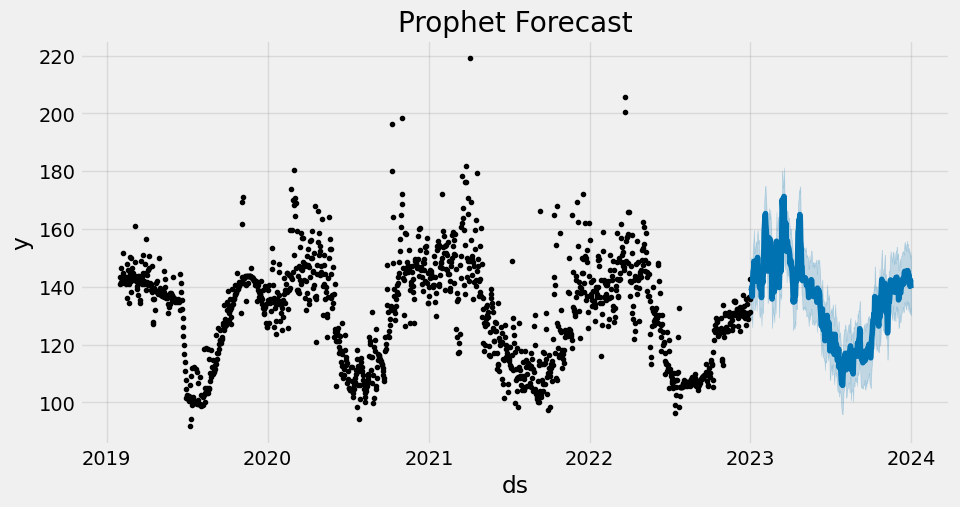

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(AQI_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

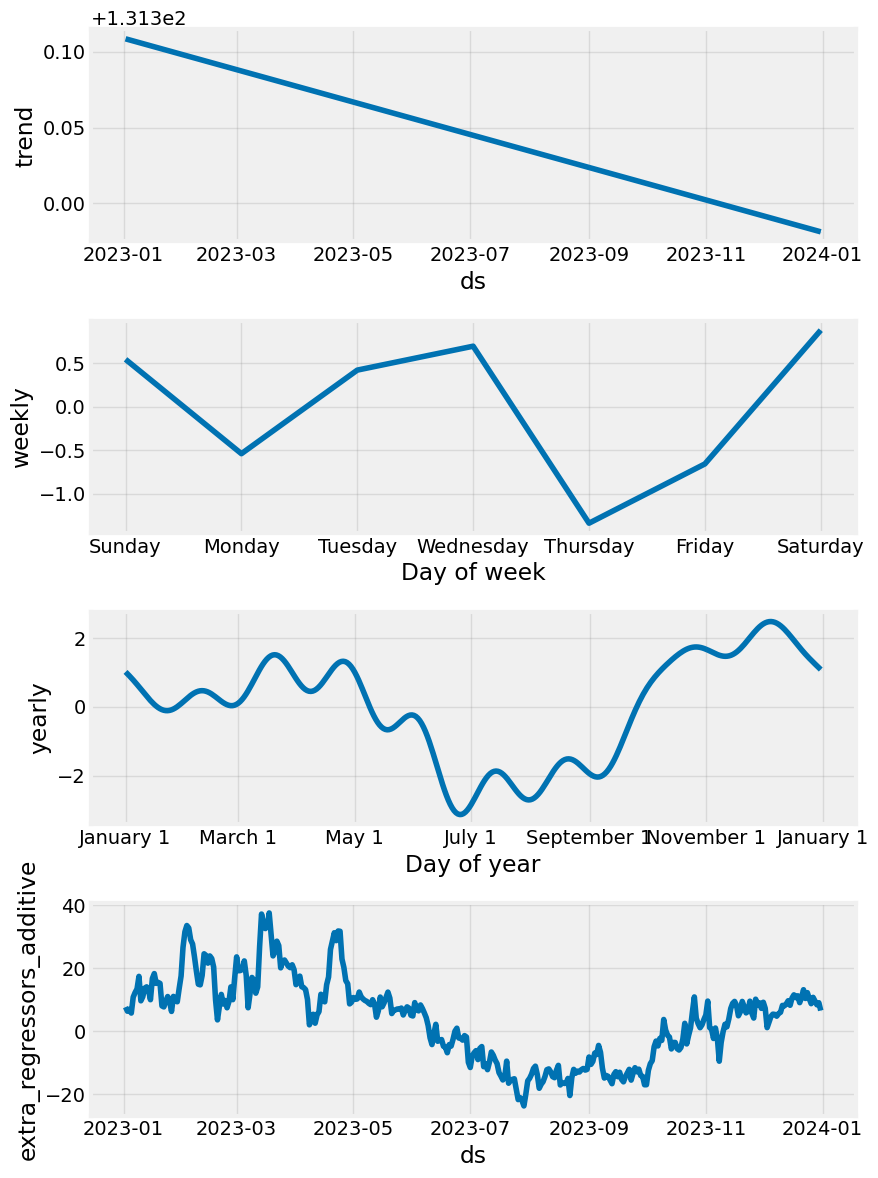

In [ ]:
fig = model.plot_components(AQI_test_fcst)
plt.show()

# Evaluation Matices


In [ ]:
np.sqrt(mean_squared_error(y_true=AQI_test['y'],
                   y_pred=AQI_test_fcst['yhat']))
mean_absolute_error(y_true=AQI_test['y'],
                   y_pred=AQI_test_fcst['yhat'])

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=AQI_test['y'],
                   y_pred=AQI_test_fcst['yhat'])

7.690961573730043

In [ ]:
mean_absolute_error(y_true=AQI_test['y'],
                   y_pred=AQI_test_fcst['yhat'])

5.798399811214223

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=AQI_test['y'],
                   y_pred=AQI_test_fcst['yhat'])

4.188086430402142

#  Forecasting into the future


In [ ]:
# @ ForeCasting into the future
AQI_train.head()

,ds,y,rolling_mean_7,rolling_mean_30,monthly_avg,quarter,lag_1,lag_7,lag_30,is_holiday,day_of_week,is_weekend
0,2019-01-31,140.981786,141.066974,141.105426,141.229067,1,140.369794,143.000180,138.335417,0,3,0
1,2019-02-01,143.421576,141.501216,141.336244,145.360022,1,140.981786,140.381882,136.497038,0,4,0
2,2019-02-02,146.446378,141.795075,141.518230,145.360022,1,143.421576,144.389359,140.986804,0,5,1
3,2019-02-03,141.627831,142.065504,141.858219,145.360022,1,146.446378,139.734832,131.428163,0,6,1
4,2019-02-04,141.356050,142.271435,142.069925,145.360022,1,141.627831,139.914534,135.004868,0,0,0


In [ ]:
AQI_train = AQI_train[['ds', 'y']]
AQI_train.head()

,ds,y
0,2019-01-31,140.981786
1,2019-02-01,143.421576
2,2019-02-02,146.446378
3,2019-02-03,141.627831
4,2019-02-04,141.356050


In [ ]:
future['rolling_mean_7'] = future['y'].rolling(window=7).mean()
future['rolling_mean_30'] = future['y'].rolling(window=30).mean()
future['lag_1'] = future['y'].shift(1)
future['lag_7'] = future['y'].shift(7)
future['lag_30'] = future['y'].shift(30)

future = future.dropna()

future['monthly_avg'] = future['ds'].dt.month
future['quarter'] = future['ds'].dt.quarter
future['is_holiday'] = future['ds'].apply(lambda x: 1 if x.month == 12 and x.day == 25 else 0)
future['day_of_week'] = future['ds'].dt.weekday
future['is_weekend'] = future['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)

future


<ipython-input-49-857a7399eac6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['rolling_mean_7'] = future['y'].rolling(window=7).mean()  # Example 7-day rolling mean
<ipython-input-49-857a7399eac6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  future['rolling_mean_30'] = future['y'].rolling(window=30).mean()  # Example 30-day rolling mean
<ipython-input-49-857a7399eac6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

,ds,y,rolling_mean_7,rolling_mean_30,lag_1,lag_7,lag_30,monthly_avg,quarter,is_holiday,day_of_week,is_weekend
60,2024-03-01,103.923684,123.246586,128.140702,134.917770,163.673426,164.106558,3,1,0,4,0
61,2024-03-02,111.638864,121.162873,126.841137,103.923684,126.224854,150.625843,3,1,0,5,1
62,2024-03-03,167.128334,128.440792,128.478081,111.638864,116.182901,118.019988,3,1,0,6,1
63,2024-03-04,160.914490,135.947024,129.178921,167.128334,108.370864,139.889303,3,1,0,0,0
64,2024-03-05,110.083156,132.575815,129.074692,160.914490,133.681625,113.210021,3,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,2024-12-26,137.294876,120.545198,129.094996,121.184083,148.454757,143.835260,12,4,0,3,0
361,2024-12-27,143.536517,121.643314,128.179776,137.294876,135.849708,170.993139,12,4,0,4,0
362,2024-12-28,136.535727,125.801383,128.571381,143.536517,107.429245,124.787567,12,4,0,5,1
363,2024-12-29,130.940155,125.289484,128.964245,136.535727,134.523443,119.154239,12,4,0,6,1


In [ ]:
forecast = model.predict(future)

# Display forecasted values for the future period
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])






            ds        yhat  yhat_lower  yhat_upper
0   2024-03-01  114.566564  105.237300  123.995605
1   2024-03-02  112.041619  103.131594  121.446669
2   2024-03-03  120.457675  111.621387  129.703799
3   2024-03-04  136.306953  126.957085  145.262325
4   2024-03-05  131.114452  121.728000  140.175323
..         ...         ...         ...         ...
300 2024-12-26  110.896421  101.016498  120.778008
301 2024-12-27  116.424405  107.782947  125.960133
302 2024-12-28  124.391194  115.524341  134.156724
303 2024-12-29  119.346749  110.415965  129.247759
304 2024-12-30  124.523880  115.650289  133.571787

[305 rows x 4 columns]
